# **Vehicle Analysis**

In [2]:

import pandas as pd
import numpy as np
from statistics import mode
import json
from datetime import datetime
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from dash import Dash, html, dcc, Input, Output,  callback
import plotly.express as px

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Data extraction

### Vehicle data

In [3]:
veh_data = pd.read_parquet(r"https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/all-vehicles-model/exports/parquet?lang=en&timezone=America%2FGuatemala")

### Vehicle metadata

In [4]:
with open(r"../files/veh_data_schema.json", "r") as f:
    veh_data_schema = json.load(f)
    veh_data_schema = veh_data_schema["definitions"]["all-vehicles-model_records"]["properties"]["fields"]["properties"]
    veh_metadata = pd.DataFrame(veh_data_schema).transpose()[["title","description","type","unit"]] 

In [5]:
new_col_names = {idx.lower():veh_metadata.title[idx].lower().replace(" ","_") for idx in veh_metadata.index}
veh_data.rename(columns = new_col_names, inplace = True)

## Data Cleaning/Wrangling

### Data understanding

In this part of the notebook the goal is to understand as much columns as possible, identifying the right ones that can be used in the model, and take out all the columns that does not have acurate data

In [6]:
veh_metadata

,title,description,type,unit
make,Make,manufacturer (division),string,NaN
model,Model,model name (carline),string,NaN
barrels08,Annual Petroleum Consumption For Fuel Type1,annual petroleum consumption in barrels for fu...,number,NaN
barrelsa08,Annual Petroleum Consumption For Fuel Type2,annual petroleum consumption in barrels for fu...,number,NaN
charge120,Time to charge at 120V,time to charge an electric vehicle in hours at...,number,NaN
charge240,Time to charge at 240V,time to charge an electric vehicle in hours at...,number,NaN
city08,City Mpg For Fuel Type1,city MPG for fuelType1,integer,NaN
city08u,Unrounded City Mpg For Fuel Type1 (2),unrounded city MPG for fuelType1 (2),number,NaN
citya08,City Mpg For Fuel Type2,city MPG for fuelType2,integer,NaN
citya08u,Unrounded City Mpg For Fuel Type2,unrounded city MPG for fuelType2,number,NaN


In this case, we'll analyze and create a model for those vehicles which year is higher or equal to 2000

In [7]:
veh_subdata = veh_data.query("year >= '2000'")[[
                                    "make",
                                    "basemodel",
                                    "model", 
                                    "year", 
                                    "vehicle_size_class",
                                    "cylinders", 
                                    "engine_displacement",# in liters 
                                    "t_charger", # has turbocharger (True/False)
                                    "s_charger", # has supercharger (True/False)
                                    "electric_motor",
                                    "transmission",
                                    "drive", #traction      
                                    "start-stop",
                                    "fuel_type", 
                                    "fuel_type1",
                                    "fuel_type2",
                                    "phev_blended",
                                    #"range_for_fuel_type1", not enough data
                                    #"range_city_for_fuel_type1", not enough data
                                    #"range_highway_for_fuel_type1", not enough data
                                    #"highway_gasoline_consumption",
                                    "city_electricity_consumption", #kWh/100 miles
                                    "city_mpg_for_fuel_type1", # miles per gallon, the mpg equivalent in electricity = 33.705*(kWh/100 miles)**-1  
                                    #"unrounded_city_mpg_for_fuel_type1_(2)",# not enough data
                                    "city_mpg_for_fuel_type2",
                                    #"unadjusted_city_mpg_for_fuel_type2",
                                    "highway_electricity_consumption",
                                    "highway_mpg_for_fuel_type1",
                                    #"unadjusted_highway_mpg_for_fuel_type1",
                                    "highway_mpg_for_fuel_type2",
                                    #"unadjusted_highway_mpg_for_fuel_type2",
                                    "combined_electricity_consumption", # combined means using the car in the city and highway
                                    "combined_mpg_for_fuel_type1",
                                    #"unrounded_combined_mpg_for_fuel_type1",
                                    "combined_mpg_for_fuel_type2", 
                                    #"unrounded_combined_mpg_for_fuel_type2",
                                    "time_to_charge_at_120v",# time in hours
                                    "time_to_charge_at_240v",# time in hours
                                    "co2_tailpipe_for_fuel_type1", # g/mile
                                    "co2_tailpipe_for_fuel_type2" # g/mile
                                    ]]

### Generating/modifying columns

In this section I modify some columns in order to get the International System units in the columns required

#### ***Datatypes***

In [8]:
veh_subdata.dtypes

make                                 object
basemodel                            object
model                                object
year                                 object
vehicle_size_class                   object
cylinders                           float64
engine_displacement                 float64
t_charger                            object
s_charger                            object
electric_motor                       object
transmission                         object
drive                                object
start-stop                           object
fuel_type                            object
fuel_type1                           object
fuel_type2                           object
phev_blended                         object
city_electricity_consumption        float64
city_mpg_for_fuel_type1               int64
city_mpg_for_fuel_type2               int64
highway_electricity_consumption     float64
highway_mpg_for_fuel_type1            int64
highway_mpg_for_fuel_type2      

In [9]:
veh_subdata.year = veh_subdata.year.astype(int)

veh_subdata.dtypes

make                                 object
basemodel                            object
model                                object
year                                  int64
vehicle_size_class                   object
cylinders                           float64
engine_displacement                 float64
t_charger                            object
s_charger                            object
electric_motor                       object
transmission                         object
drive                                object
start-stop                           object
fuel_type                            object
fuel_type1                           object
fuel_type2                           object
phev_blended                         object
city_electricity_consumption        float64
city_mpg_for_fuel_type1               int64
city_mpg_for_fuel_type2               int64
highway_electricity_consumption     float64
highway_mpg_for_fuel_type1            int64
highway_mpg_for_fuel_type2      

#### ***mpg*** (miles per gallon) to ***kmpl*** (km per liter)

- 1 mpg = 0.354006 kmpl

In [10]:
def mpg_to_kmpl(cols:list, df:pd.DataFrame)->pd.DataFrame:
    new_df = df.copy()
    for col in cols:
        new_df[col] = new_df[col]*0.354006 #convertion to km/l = kmpl
        new_col_name = col.replace("mpg","kmpl")
        new_df.rename(columns = {col:new_col_name}, inplace=True)
    return new_df    

In [11]:
mpg_cols = [x for x in veh_subdata.columns if "mpg" in x]
veh_subdata2 = mpg_to_kmpl(mpg_cols, veh_subdata)

In [12]:
veh_subdata2.sample(20)

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,co2_tailpipe_for_fuel_type1,co2_tailpipe_for_fuel_type2
7011,Mercedes-Benz,E-Class,E320,2002,Midsize Cars,6.0,3.2,None,None,None,Automatic 5-spd,Rear-Wheel Drive,None,Premium,Premium Gasoline,None,false,0.0,6.372108,0.000000,0.0,9.204156,0.000000,0.0,7.434126,0.000000,0.0,0.0,423.190476,0.000000
34342,Volkswagen,Taos,Taos,2023,Small Sport Utility Vehicle 2WD,4.0,1.5,T,None,None,Automatic (S8),Front-Wheel Drive,Y,Regular,Regular Gasoline,None,false,0.0,9.912168,0.000000,0.0,12.744216,0.000000,0.0,10.974186,0.000000,0.0,0.0,286.000000,0.000000
7716,Jeep,Cherokee,Cherokee 4WD Active Drive II,2015,Small Sport Utility Vehicle 4WD,6.0,3.2,None,None,None,Automatic 9-spd,4-Wheel Drive,Y,Regular,Regular Gasoline,None,false,0.0,6.726114,0.000000,0.0,9.204156,0.000000,0.0,7.434126,0.000000,0.0,0.0,415.000000,0.000000
16293,Volvo,XC90,XC90 AWD,2005,Sport Utility Vehicle - 4WD,5.0,2.5,T,None,None,Automatic (S5),4-Wheel or All-Wheel Drive,None,Premium,Premium Gasoline,None,false,0.0,5.310090,0.000000,0.0,7.080120,0.000000,0.0,6.018102,0.000000,0.0,0.0,522.764706,0.000000
12752,Nissan,350z,350z,2007,Two Seaters,6.0,3.5,None,None,None,Manual 6-spd,Rear-Wheel Drive,None,Premium,Premium Gasoline,None,false,0.0,6.372108,0.000000,0.0,8.850150,0.000000,0.0,7.080120,0.000000,0.0,0.0,444.350000,0.000000
11388,Saab,9-3,9-3 SportCombi,2007,Small Station Wagons,6.0,2.8,T,None,None,Manual 6-spd,Front-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0,5.664096,0.000000,0.0,9.204156,0.000000,0.0,6.726114,0.000000,0.0,0.0,467.736842,0.000000
22873,Lexus,LX,LX 470,2005,Sport Utility Vehicle - 4WD,8.0,4.7,None,None,None,Automatic 5-spd,4-Wheel or All-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0,4.248072,0.000000,0.0,5.664096,0.000000,0.0,4.602078,0.000000,0.0,0.0,683.615385,0.000000
47247,Mazda,Tribute,Tribute 4WD,2011,Sport Utility Vehicle - 4WD,4.0,2.5,None,None,None,Automatic 6-spd,All-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0,7.080120,0.000000,0.0,9.204156,0.000000,0.0,7.788132,0.000000,0.0,0.0,403.954545,0.000000
20965,Hyundai,Elantra,Elantra,2014,Midsize Cars,4.0,1.8,None,None,None,Automatic 6-spd,Front-Wheel Drive,N,Regular,Regular Gasoline,None,false,0.0,9.558162,0.000000,0.0,13.098222,0.000000,0.0,10.974186,0.000000,0.0,0.0,285.000000,0.000000
3407,Cadillac,XTS,XTS AWD,2019,Large Cars,6.0,3.6,T,None,None,Automatic (S6),All-Wheel Drive,N,Premium,Premium Gasoline,None,false,0.0,5.664096,0.000000,0.0,8.142138,0.000000,0.0,6.372108,0.000000,0.0,0.0,486.000000,0.000000


#### ***miles*** to ***km***

- 1 mile = 1.60934 km

In [13]:
def miles_to_kms(cols:list, df:pd.DataFrame)->pd.DataFrame:
    new_df = df.copy()
    for col in cols:
        new_df[col] = new_df[col]*(1/1.60934)#convert mile to km
        if "electricity_consumption" in col:
            new_df.rename(columns={col:col+"_kwhpkm"}, inplace=True)
        else:
            new_df.rename(columns={col:col+"_gpkm"}, inplace=True)
    return new_df

In [14]:
miles_columns = ["city_electricity_consumption", # kwh/mile
                 "highway_electricity_consumption", # kwh/mile
                 "combined_electricity_consumption",# kwh/mile
                 "co2_tailpipe_for_fuel_type1",# g/mile
                 "co2_tailpipe_for_fuel_type2"# g/mile
                 ]

In [15]:
veh_subdata3 = miles_to_kms(miles_columns, veh_subdata2)
veh_subdata3.head()

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
0,Kia,Sedona,Sedona,2017,Minivan - 2WD,6.0,3.3,None,None,None,Automatic (S6),Front-Wheel Drive,N,Regular,Regular Gasoline,None,false,0.0,6.372108,0.0,0.0,8.496144,0.0,0.0,7.080120,0.0,0.0,0.0,275.268122,0.0
1,Genesis,G80,G80 AWD,2017,Large Cars,6.0,3.8,None,None,None,Automatic (S8),All-Wheel Drive,N,Regular,Regular Gasoline,None,false,0.0,5.664096,0.0,0.0,8.850150,0.0,0.0,6.726114,0.0,0.0,0.0,285.210086,0.0
2,Roush Performance,F150,F150 Pickup 2WD,2016,Standard Pickup Trucks 2WD,8.0,5.0,None,S,None,Automatic (S6),Rear-Wheel Drive,N,Premium,Premium Gasoline,None,false,0.0,4.248072,0.0,0.0,5.310090,0.0,0.0,4.602078,0.0,0.0,0.0,398.299924,0.0
3,Infiniti,Q50,Q50 AWD,2016,Midsize Cars,6.0,3.0,T,None,None,Automatic (S7),All-Wheel Drive,N,Premium,Premium Gasoline,None,false,0.0,6.726114,0.0,0.0,9.558162,0.0,0.0,7.788132,0.0,0.0,0.0,252.277331,0.0
4,Porsche,Macan,Macan Turbo,2017,Small Sport Utility Vehicle 4WD,6.0,3.6,T,None,None,Automatic (AM-S7),All-Wheel Drive,Y,Premium,Premium Gasoline,None,false,0.0,6.018102,0.0,0.0,8.142138,0.0,0.0,6.726114,0.0,0.0,0.0,290.181068,0.0


#### defining the time unit in time columns
- time unit: hours

In [16]:
veh_subdata3.rename(columns = {
                    "time_to_charge_at_120v":"hours_to_charge_at_120v",
                    "time_to_charge_at_240v":"hours_to_charge_at_240v"
                    }, 
                    inplace=True
                    )

#### Dropping duplicates

In [17]:
veh_subdata4 = veh_subdata3.drop_duplicates(keep="first", subset =[
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "transmission",
                                                "drive", #traction      
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended"
                                             ])

In [18]:
len(veh_subdata4)

29111

#### Finding missing values

In [19]:
cols_w_na = veh_subdata4.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
5,cylinders,787
6,engine_displacement,786
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### cylinders

In [20]:
veh_subdata4.query("cylinders.isna() == True").fuel_type.value_counts()

fuel_type
Electricity    755
Hydrogen        32
Name: count, dtype: int64

All of the vehicles that doesn't have cylinders is because they're electric, so cylinders must be 0

In [21]:
veh_subdata4.query("cylinders.isna()==True and engine_displacement.isna() == False")

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,hours_to_charge_at_120v,hours_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
12131,Mitsubishi,i-MiEV,i-MiEV,2016,Subcompact Cars,NaN,0.0,None,None,49 kW DCPM,Automatic (A1),Rear-Wheel Drive,N,Electricity,Electricity,None,false,16.777064,44.604756,0.0,21.126673,35.046594,0.0,18.641182,39.648672,0.0,0.0,7.0,0.0,0.0


In [22]:
veh_subdata5 = veh_subdata4.copy()
veh_subdata5.cylinders = veh_subdata5.cylinders.fillna(0)

In [23]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
6,engine_displacement,786
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### engine displacement

In [24]:
veh_subdata5[veh_subdata5.engine_displacement.isna() == True].fuel_type.value_counts()

fuel_type
Electricity    754
Hydrogen        32
Name: count, dtype: int64

In [25]:
veh_subdata5.engine_displacement = veh_subdata5.engine_displacement.fillna(0) 

In [26]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
7,t_charger,20174
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### t_charger

In [27]:
veh_subdata5.t_charger.value_counts()

t_charger
T    8937
Name: count, dtype: int64

In [28]:
veh_subdata5.loc[veh_subdata5.t_charger == "T","t_charger"] = True
veh_subdata5.loc[veh_subdata5.t_charger.isna() == True,"t_charger"] = False

In [29]:
veh_subdata5.t_charger.value_counts()

t_charger
False    20174
True      8937
Name: count, dtype: int64

In [30]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
8,s_charger,28170
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### s_charger

In [31]:
veh_subdata5.s_charger.value_counts().reset_index()

,s_charger,count
0,S,941


In [32]:
len(veh_subdata5[veh_subdata5.s_charger.isna()==False])

941

In [33]:
veh_subdata5.loc[veh_subdata5.s_charger.isna()==False, "s_charger"] = True
veh_subdata5.loc[veh_subdata5.s_charger.isna()==True, "s_charger"] = False
veh_subdata5.s_charger.value_counts()

s_charger
False    28170
True       941
Name: count, dtype: int64

In [34]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
9,electric_motor,26692
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### electric motor

In [35]:
veh_subdata5.query("electric_motor.isna()==True").fuel_type.value_counts()

fuel_type
Regular                    13126
Premium                    11396
Gasoline or E85             1384
Diesel                       434
Midgrade                     148
Premium or E85               128
CNG                           47
Gasoline or natural gas       20
Gasoline or propane            8
Electricity                    1
Name: count, dtype: int64

In [36]:
veh_subdata5.query("(electric_motor.isna()==True) & (fuel_type == 'Electricity') ")
veh_subdata5.loc[(veh_subdata5.electric_motor.isna()==True) & (veh_subdata5.fuel_type == "Electricity"), "electric_motor"] = "TBD"
veh_subdata5.loc[veh_subdata5.electric_motor.isna()==True, "electric_motor"] = "None"

In [37]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
10,transmission,9
11,drive,4
12,start-stop,13478
15,fuel_type2,27229


##### fuel type 2

In [38]:
veh_subdata5.query("fuel_type2.isna()==True").fuel_type.value_counts()

fuel_type
Regular        13773
Premium        12024
Electricity      755
Diesel           434
Midgrade         164
CNG               47
Hydrogen          32
Name: count, dtype: int64

In [39]:
veh_subdata5.loc[veh_subdata5.fuel_type2.isna()==True, "fuel_type2"] = "None"

In [40]:
cols_w_na = veh_subdata5.isna().sum().reset_index(drop=False).rename(columns={0:"na_values","index":"cols"}).query("na_values > 0")
cols_w_na

,cols,na_values
10,transmission,9
11,drive,4
12,start-stop,13478


##### transmission

In [41]:
print(f"Number of rows where transmission is null: {len(veh_subdata5.query('transmission.isna() == True')):,}")
print(f"different fuel type where transmission is null: {veh_subdata5.query('transmission.isna()==True').fuel_type.unique()}")

Number of rows where transmission is null: 9
different fuel type where transmission is null: ['Electricity']


In [42]:
veh_subdata5.query("fuel_type == 'Electricity'").transmission.value_counts()

transmission
Automatic (A1)                      673
Automatic (A2)                       64
Automatic (variable gear ratios)      9
Name: count, dtype: int64

As all the transmission values that are missing are from the fuel type 'Electricity', I'll create a
subset of the data with only this type of fuel.

Then I need to find the index where the null values are to identify them when replacing the original dataset

In [43]:
index_of_transmission_na = veh_subdata5.query("fuel_type == 'Electricity'").reset_index(drop=True).query("transmission.isna()==True").index
index_of_transmission_na

Index([17, 40, 41, 138, 298, 349, 400, 477, 573], dtype='int64')

In [44]:
cols_predict_transmission = [
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "drive", #traction      
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended",
                                                "transmission"
                                             ]

To figure out the right transmission for the vehicles with na values, I'll use the KNNImputer from
sklearn.

This imputation model sets the mean of the KNN values to the null values

As this model only accepts numerical values, all the categorical ones must be transform, we'll use
an ordinal encoder due to the number does not matter

In [45]:
#transmission_data = veh_subdata5.query("fuel_type == 'Electricity'")[cols_predict_transmission].reset_index(drop=True)
transmission_data = veh_subdata5[cols_predict_transmission].query("fuel_type == 'Electricity'")

In [46]:
transmission_data.loc[transmission_data.transmission.isna()==True, "transmission"] = np.nan #required to OrdinalEncoder to keep the null values
print(transmission_data.transmission.isna().sum())

9


In [47]:
cat_features_encoder = preprocessing.OrdinalEncoder() # encode each feature from 0 to (n-1) where n is the number of diff classes in the feature

In [48]:
transmission_transformed = cat_features_encoder.fit_transform(transmission_data)

In [49]:
np.unique(transmission_transformed[:,-1])

array([ 0.,  1.,  2., nan])

In [50]:
np.isnan(transmission_transformed[:,-1]).sum()

np.int64(9)

In [51]:
transmission_imputer = KNNImputer()

In [52]:
transmission_imputed = transmission_imputer.fit_transform(transmission_transformed)
transmission_imputed = transmission_imputed.astype(int) #as KNN gives the mean value and the ordinal encoder only gives int values
np.unique(transmission_imputed[:,-1])

array([0, 1, 2])

In [53]:
transmission_data_fitted = cat_features_encoder.inverse_transform(transmission_imputed)

In [54]:
transmission_fitted = pd.DataFrame(transmission_data_fitted, columns = cols_predict_transmission)

Making sure all the values are filled now

In [55]:
transmission_fitted.transmission.isna().sum()

np.int64(0)

Figuring out how all the null values where set with the imputation model

In [56]:
transmission_fitted.loc[index_of_transmission_na,"transmission"]

17     Automatic (A1)
40     Automatic (A1)
41     Automatic (A1)
138    Automatic (A1)
298    Automatic (A1)
349    Automatic (A1)
400    Automatic (A1)
477    Automatic (A1)
573    Automatic (A1)
Name: transmission, dtype: object

<Axes: xlabel='Count', ylabel='transmission'>

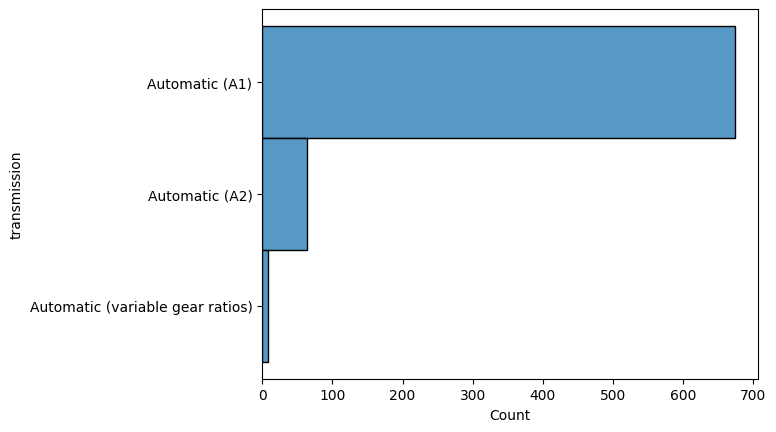

In [57]:
sns.histplot(data=veh_subdata5.query("fuel_type == 'Electricity'"), y = "transmission")

<Axes: xlabel='Count', ylabel='transmission'>

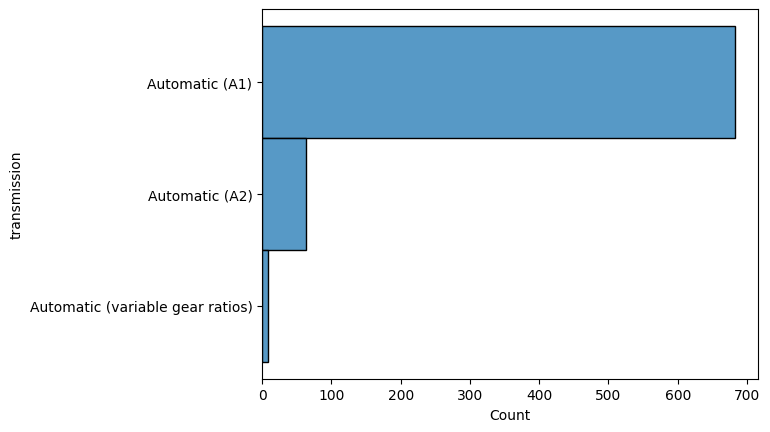

In [58]:
sns.histplot(transmission_fitted.query("fuel_type == 'Electricity'"), y = "transmission")

In [59]:
veh_subdata5.query("transmission.isna()==True")

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption_kwhpkm,city_kmpl_for_fuel_type1,city_kmpl_for_fuel_type2,highway_electricity_consumption_kwhpkm,highway_kmpl_for_fuel_type1,highway_kmpl_for_fuel_type2,combined_electricity_consumption_kwhpkm,combined_kmpl_for_fuel_type1,combined_kmpl_for_fuel_type2,hours_to_charge_at_120v,hours_to_charge_at_240v,co2_tailpipe_for_fuel_type1_gpkm,co2_tailpipe_for_fuel_type2_gpkm
1408,Toyota,RAV4,RAV4 EV,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,false,24.233537,30.798522,0.0,30.447264,24.426414,0.0,26.719028,27.612468,0.0,0.0,0.0,0.0,0.0
2616,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,None,None,N,Electricity,Electricity,None,false,25.476282,28.674486,0.0,22.990791,32.214546,0.0,24.854909,30.090510,0.0,0.0,0.0,0.0,0.0
2617,Toyota,RAV4,RAV4 EV,2000,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,false,25.476282,28.674486,0.0,32.932755,22.656384,0.0,29.204519,25.488432,0.0,0.0,0.0,0.0,0.0
8681,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,None,None,N,Electricity,Electricity,None,false,28.583146,26.196444,0.0,36.660991,20.532348,0.0,32.311382,23.010390,0.0,0.0,0.0,0.0,0.0
17938,Ford,Explorer,Explorer USPS Electric,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,None,2-Wheel Drive,N,Electricity,Electricity,None,false,46.602955,15.930270,0.0,63.380019,11.682198,0.0,54.059428,13.806234,0.0,0.0,0.0,0.0,0.0
21370,Toyota,RAV4,RAV4 EV,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,false,25.476282,28.674486,0.0,32.932755,22.656384,0.0,29.204519,25.488432,0.0,0.0,0.0,0.0,0.0
24738,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,None,None,N,Electricity,Electricity,None,false,24.854909,29.736504,0.0,31.690010,23.364396,0.0,27.961773,26.550450,0.0,0.0,0.0,0.0,0.0
29650,Toyota,RAV4,RAV4 EV,2003,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,None,2-Wheel Drive,N,Electricity,Electricity,None,false,24.233537,30.798522,0.0,30.447264,24.426414,0.0,26.719028,27.612468,0.0,0.0,0.0,0.0,0.0
36994,Ford,Explorer,Explorer USPS Electric,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,None,2-Wheel Drive,N,Electricity,Electricity,None,false,46.602955,15.930270,0.0,63.380019,11.682198,0.0,54.059428,13.806234,0.0,0.0,0.0,0.0,0.0


In [60]:
transmission_fitted.loc[index_of_transmission_na, :]

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,transmission
17,Toyota,RAV4,RAV4 EV,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)
40,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,None,N,Electricity,Electricity,None,false,Automatic (A1)
41,Toyota,RAV4,RAV4 EV,2000,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)
138,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,None,N,Electricity,Electricity,None,false,Automatic (A1)
298,Ford,Explorer,Explorer USPS Electric,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)
349,Toyota,RAV4,RAV4 EV,2001,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)
400,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,None,N,Electricity,Electricity,None,false,Automatic (A1)
477,Toyota,RAV4,RAV4 EV,2003,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,50 KW DC,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)
573,Ford,Explorer,Explorer USPS Electric,2002,Sport Utility Vehicle - 2WD,0.0,0.0,False,False,67 KW AC Induction,2-Wheel Drive,N,Electricity,Electricity,None,false,Automatic (A1)


In [61]:
original_index = veh_subdata5[veh_subdata5.transmission.isna()==True].index.tolist()
veh_subdata6 = veh_subdata5.copy()
veh_subdata6.loc[original_index, "transmission"] = transmission_fitted.loc[index_of_transmission_na, "transmission"].tolist()

In [62]:
veh_subdata6.isna().sum().reset_index(drop=False).rename(columns = {"index":"cols", 0:"na_values"}).query("na_values>0")

,cols,na_values
11,drive,4
12,start-stop,13478


#### drive

In [63]:
veh_subdata6.drive.value_counts(dropna=False)

drive
Front-Wheel Drive             8841
Rear-Wheel Drive              8813
All-Wheel Drive               5447
4-Wheel or All-Wheel Drive    3194
4-Wheel Drive                 2226
Part-time 4-Wheel Drive        574
2-Wheel Drive                   12
None                             4
Name: count, dtype: int64

In [64]:
veh_subdata6.query("drive.isna()==True").fuel_type.unique()

array(['Electricity'], dtype=object)

As the missing drive values are all from electric vehicles, the same KNN imputation model will be used

In [65]:
cols_predict_drive = [
                                                "make",
                                                "basemodel",
                                                "model", 
                                                "year", 
                                                "vehicle_size_class",
                                                "cylinders", 
                                                "engine_displacement",# in liters 
                                                "t_charger", # has turbocharger (True/False)
                                                "s_charger", # has supercharger (True/False)
                                                "electric_motor",
                                                "start-stop",
                                                "fuel_type", 
                                                "fuel_type1",
                                                "fuel_type2",
                                                "phev_blended",
                                                "transmission",
                                                "drive" #traction     
                                             ]

In [66]:
drive_electric_data = veh_subdata6[cols_predict_drive].query("fuel_type=='Electricity'")

In [67]:
index_na_vals = drive_electric_data.reset_index(drop=True).query("drive.isna()==True").index

In [68]:
drive_electric_data.loc[drive_electric_data.drive.isna()==True,"drive"] = np.nan

In [69]:
encoder = preprocessing.OrdinalEncoder()
drive_electric_encoded = encoder.fit_transform(drive_electric_data)
np.isnan(drive_electric_encoded[:,-1]).sum()

np.int64(4)

In [70]:
imputer = KNNImputer()
drive_imputed = imputer.fit_transform(drive_electric_encoded) 
drive_imputed = drive_imputed.astype(int)
drive_decoded = encoder.inverse_transform(drive_imputed)
drive_decoded = pd.DataFrame(drive_decoded, columns = cols_predict_drive)

In [71]:
drive_decoded.loc[index_na_vals, :]

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,transmission,drive
40,Nissan,Altra EV,Altra EV,2000,Midsize Station Wagons,0.0,0.0,False,False,62 KW AC Induction,N,Electricity,Electricity,None,false,Automatic (A1),Front-Wheel Drive
138,Ford,Th!nk,Th!nk,2001,Two Seaters,0.0,0.0,False,False,27 KW AC Induction,N,Electricity,Electricity,None,false,Automatic (A1),Part-time 4-Wheel Drive
182,MINI,MiniE,MiniE,2008,Minicompact Cars,0.0,0.0,False,False,150 kW,N,Electricity,Electricity,None,false,Automatic (A1),All-Wheel Drive
400,Nissan,Hyper-Mini,Hyper-Mini,2001,Two Seaters,0.0,0.0,False,False,24 KW AC Synchronous,N,Electricity,Electricity,None,false,Automatic (A1),All-Wheel Drive


In [72]:
drive_electric_data.drive.value_counts().reset_index(drop=False)

,drive,count
0,All-Wheel Drive,387
1,Rear-Wheel Drive,154
2,Front-Wheel Drive,130
3,Part-time 4-Wheel Drive,53
4,4-Wheel Drive,19
5,2-Wheel Drive,8


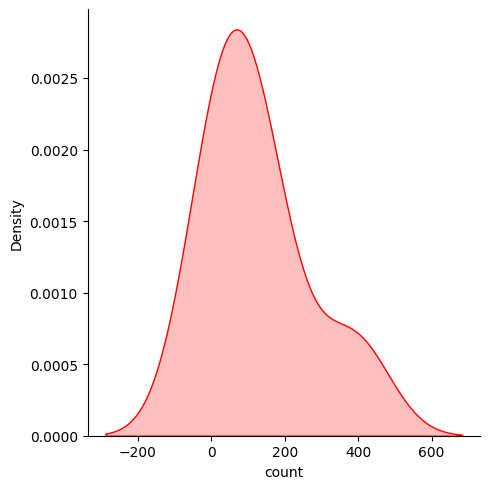

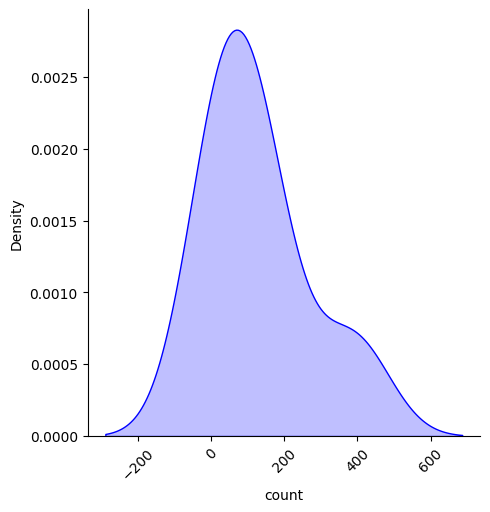

In [73]:
sns.displot(data = drive_electric_data.drive.value_counts().reset_index(drop=False), x ="count", kind = "kde", color = "red", fill = True )
sns.displot(data = drive_decoded.drive.value_counts().reset_index(drop=False), x ="count", kind = "kde", color = "blue", fill=True )
plt.xticks(rotation = 45)
plt.show()

In [74]:
veh_subdata7 = veh_subdata6.copy()
veh_subdata7.loc[veh_subdata6.drive.isna()==True,"drive"] = drive_decoded.loc[index_na_vals, "drive"].tolist()

In [75]:
veh_subdata7.isna().sum().reset_index(drop=False).rename(columns = {"index":"cols", 0:"na_values"}).query("na_values>0")

,cols,na_values
12,start-stop,13478


#### start-stop

In [76]:
veh_subdata7[veh_subdata7["start-stop"].isna()==False][["start-stop","year"]].value_counts(dropna=False, ascending=False).reset_index(drop=False)

,start-stop,year,count
0,N,2013,985
1,N,2015,971
2,N,2014,960
3,N,2016,888
4,N,2017,839
5,Y,2023,834
6,Y,2022,814
7,Y,2024,769
8,Y,2021,744
9,N,2018,722


In [77]:
veh_subdata7.loc[(veh_subdata7["start-stop"].isna()==True) | (veh_subdata7["start-stop"] == "N"), "start-stop"] = False
veh_subdata7.loc[veh_subdata7["start-stop"] == "Y", "start-stop"] = True

In [78]:
veh_subdata7["start-stop"].value_counts()

start-stop
False    22008
True      7103
Name: count, dtype: int64

### Exporting Data Cleaned

In [93]:
veh_subdata7.to_csv("../files/vehicle_data_prepared.csv", index = False)

### Numerical Data

In [80]:
veh_subdata7.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29111 entries, 0 to 47522
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   make                                     29111 non-null  object 
 1   basemodel                                29111 non-null  object 
 2   model                                    29111 non-null  object 
 3   year                                     29111 non-null  int64  
 4   vehicle_size_class                       29111 non-null  object 
 5   cylinders                                29111 non-null  float64
 6   engine_displacement                      29111 non-null  float64
 7   t_charger                                29111 non-null  object 
 8   s_charger                                29111 non-null  object 
 9   electric_motor                           29111 non-null  object 
 10  transmission                             29111 non-

In [81]:
num_data = veh_data._get_numeric_data()

In [82]:
num_data.describe()

,annual_petroleum_consumption_for_fuel_type1,annual_petroleum_consumption_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,city_mpg_for_fuel_type1,unrounded_city_mpg_for_fuel_type1_(2),city_mpg_for_fuel_type2,unrounded_city_mpg_for_fuel_type2,city_gasoline_consumption,city_electricity_consumption,epa_city_utility_factor,co2_fuel_type1,co2_fuel_type2,co2_tailpipe_for_fuel_type2,co2_tailpipe_for_fuel_type1,combined_mpg_for_fuel_type1,unrounded_combined_mpg_for_fuel_type1,combined_mpg_for_fuel_type2,unrounded_combined_mpg_for_fuel_type2,combined_electricity_consumption,combined_gasoline_consumption,epa_combined_utility_factor,cylinders,engine_displacement,epa_fuel_economy_score,annual_fuel_cost_for_fuel_type1,annual_fuel_cost_for_fuel_type2,ghg_score,ghg_score_alternative_fuel,highway_mpg_for_fuel_type1,unrounded_highway_mpg_for_fuel_type1,highway_mpg_for_fuel_type2,unrounded_highway_mpg_for_fuel_type2,highway_gasoline_consumption,highway_electricity_consumption,epa_highway_utility_factor,hatchback_luggage_volume,hatchback_passenger_volume,2_door_luggage_volume,4_door_luggage_volume,2-door_passenger_volume,4-door_passenger_volume,range_for_fuel_type1,range_city_for_fuel_type1,range_city_for_fuel_type2,range_highway_for_fuel_type1,range_highway_for_fuel_type2,unadjusted_city_mpg_for_fuel_type1,unadjusted_city_mpg_for_fuel_type2,unadjusted_highway_mpg_for_fuel_type1,unadjusted_highway_mpg_for_fuel_type2,you_save/spend,charge240b,phev_city,phev_highway,phev_combined
count,47523.000000,47523.000000,47523.0,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.00000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,46722.000000,46724.000000,15512.000000,47523.000000,47523.000000,15512.000000,729.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.00000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000,47523.000000
mean,15.173212,0.190030,0.0,0.178136,19.662079,8.940989,0.896303,0.770897,0.000501,0.981353,0.003658,125.518402,5.769291,16.18248,452.962060,21.829788,9.764593,0.945269,0.799961,1.002357,0.000393,0.003622,5.701575,3.272838,5.112945,2981.312207,115.731330,5.131189,4.074074,25.601414,11.212158,1.035793,0.860892,0.000232,1.027378,0.003573,1.926015,9.739621,1.71881,5.908991,13.030385,32.978495,4.212318,1.632149,0.197188,1.517854,0.184759,25.073608,1.196986,35.997452,0.987824,-5385.355512,0.015435,0.311302,0.313553,0.310923
std,4.488236,0.976448,0.0,1.313176,11.914322,15.857898,6.821359,6.755519,0.036616,6.637931,0.044801,197.212236,56.718117,89.72145,133.224075,11.178347,16.063208,6.742997,6.639258,6.712149,0.031883,0.044296,1.772368,1.353612,1.997131,885.474882,635.147959,2.047027,1.607845,10.527150,17.006939,6.818559,6.656468,0.026479,6.821801,0.043643,5.870081,27.472945,4.24827,9.466032,30.565695,45.921929,34.297532,20.979617,2.881204,19.724843,2.611687,17.067712,9.648902,15.083867,6.637179,4445.321813,0.321030,4.035418,3.894750,3.946077
min,0.047081,0.000000,0.0,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-38500.000000,0.000000,0.000000,0.000000,0.000000
25%,12.396250,0.000000,0.0,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.00000,373.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.200

#### Missing data

In [83]:
cols_w_empty_vals = (num_data.isna().sum()).reset_index(drop=False).rename(columns={"index":"col",0:"empty_rows"})
cols_w_empty_vals = cols_w_empty_vals.query("empty_rows > 0") 

In [84]:
cols_w_empty_vals

,col,empty_rows
22,cylinders,801
23,engine_displacement,799
24,epa_fuel_economy_score,32011
27,ghg_score,32011
28,ghg_score_alternative_fuel,46794


##### ***cylinders*** column

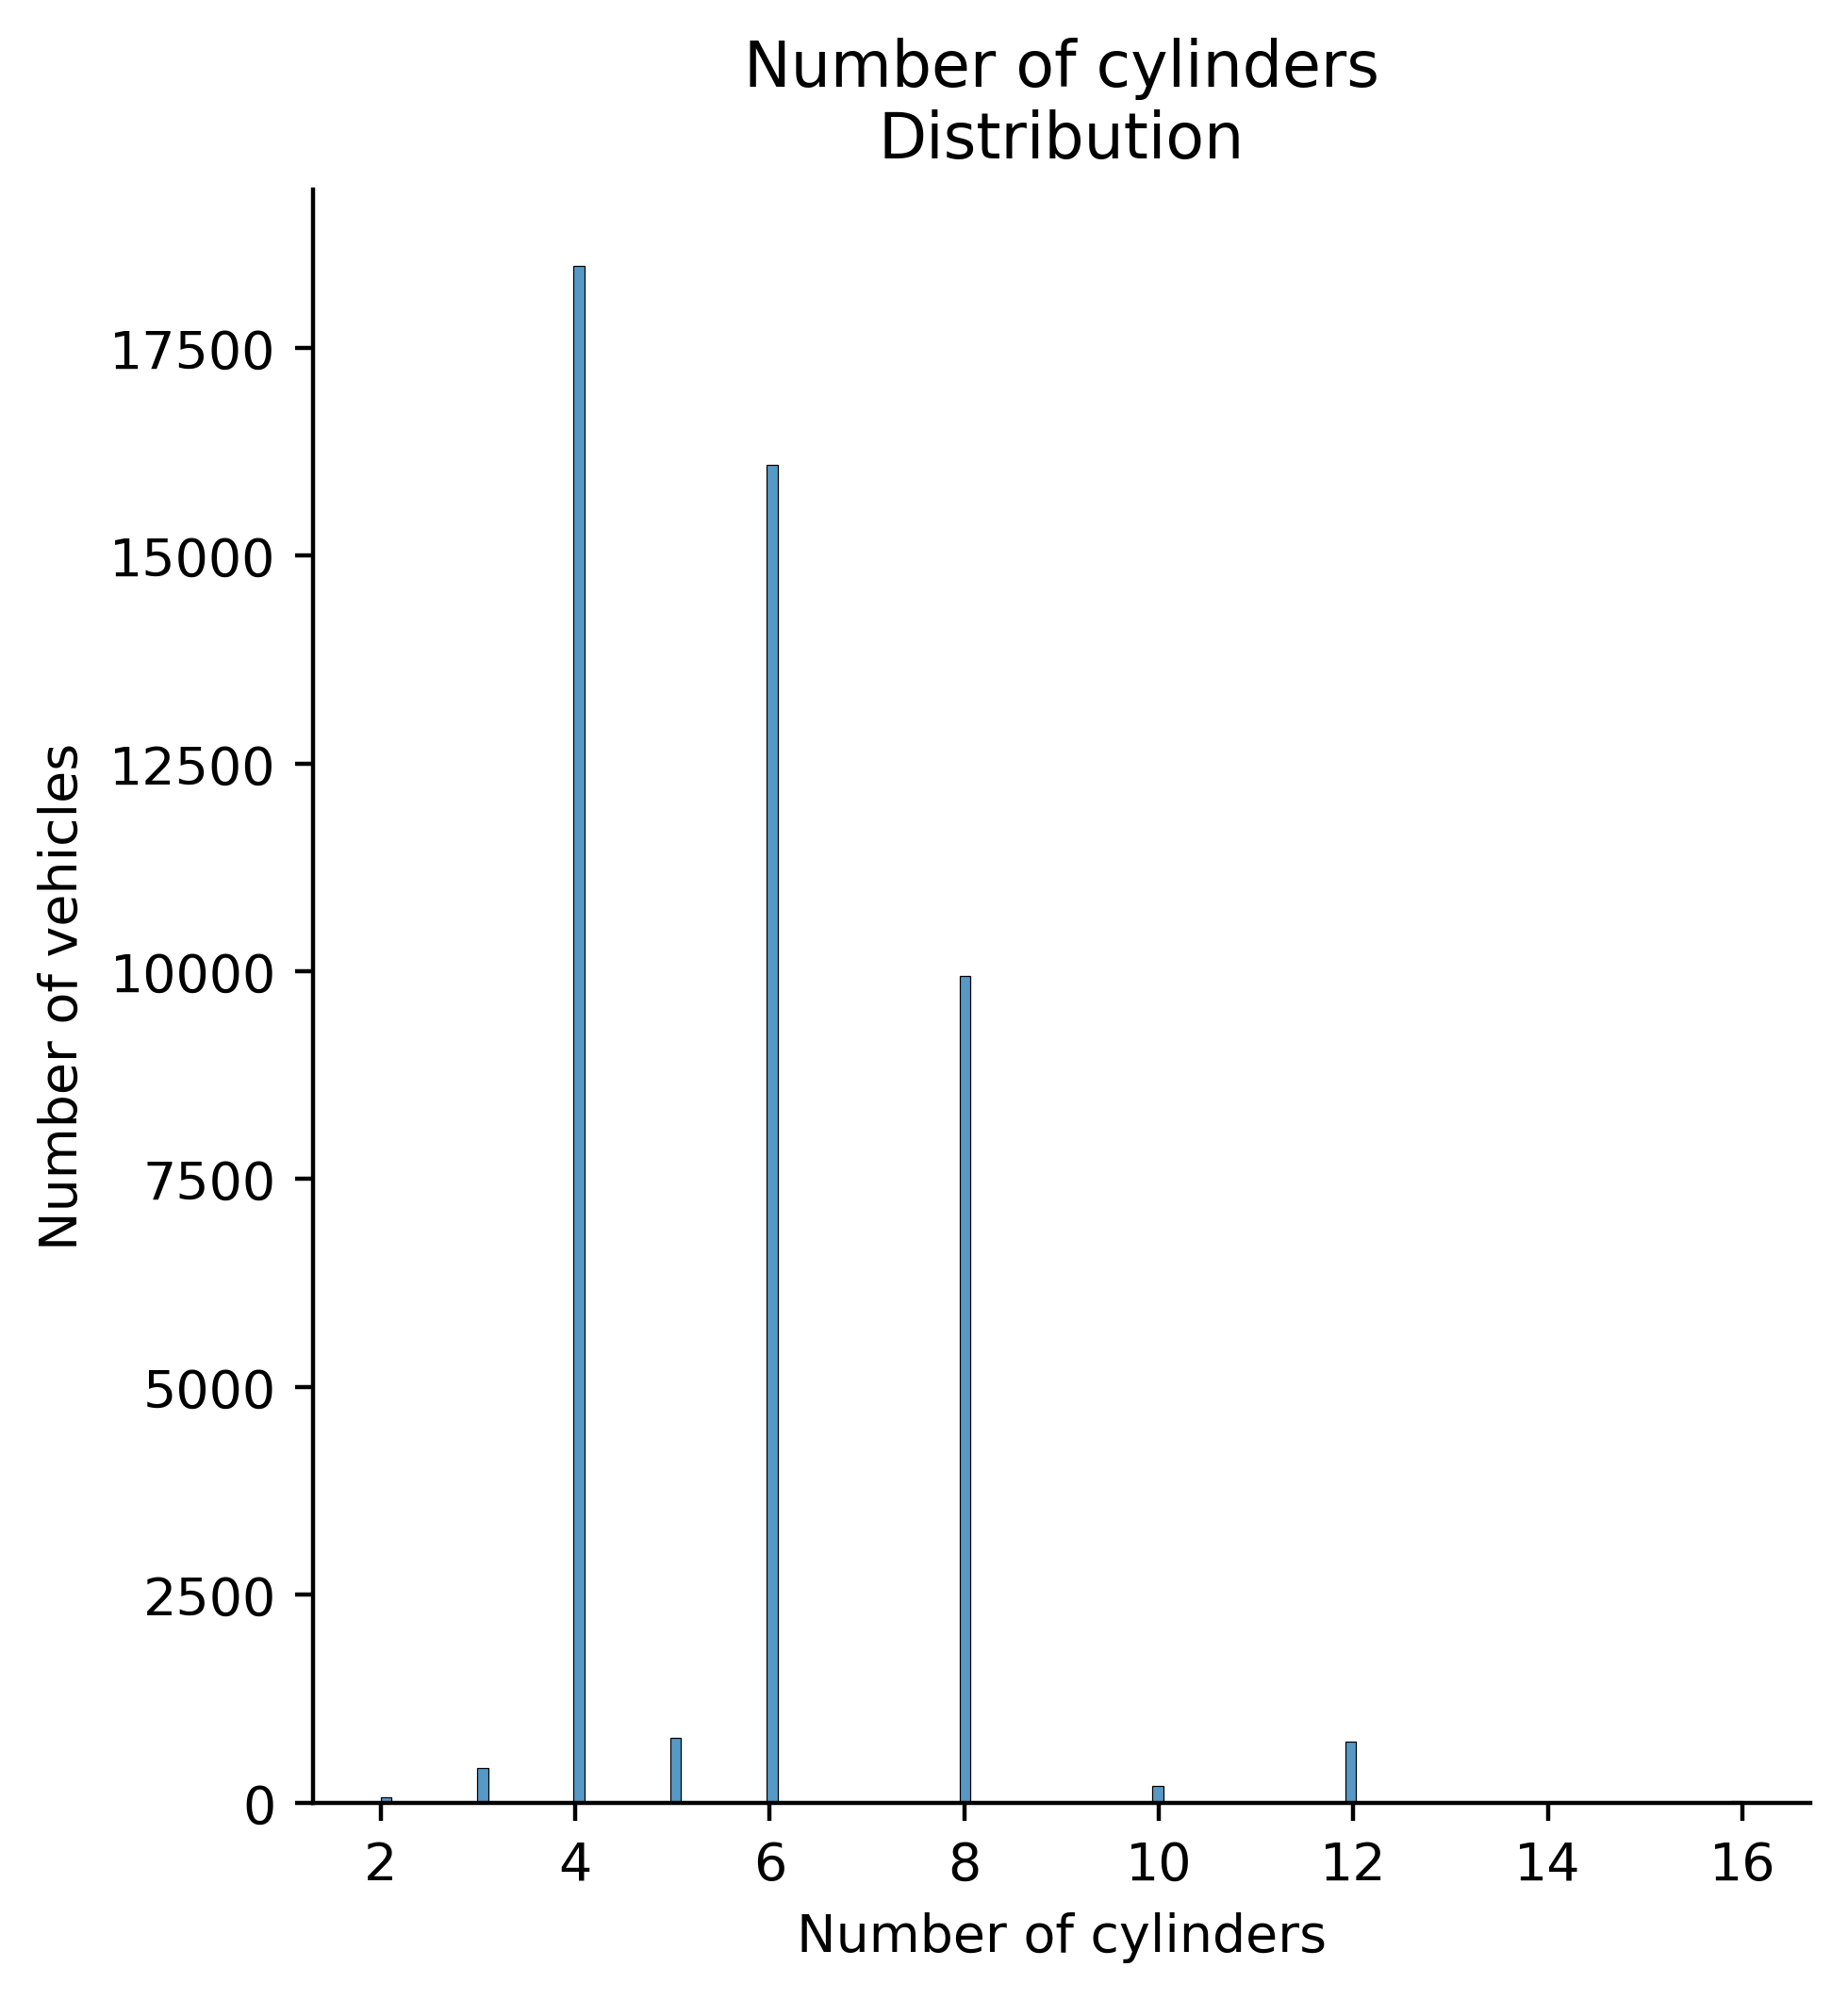

In [85]:
plt.rcParams["figure.dpi"]=400
sns.displot(data = veh_data, x = "cylinders", kind = "hist")
plt.title("Number of cylinders\nDistribution")
plt.ylabel("Number of vehicles")
plt.xlabel("Number of cylinders")
plt.show()

In [86]:
veh_data[veh_data.cylinders.isna()==True][["make","model","basemodel", "fuel_type" ,"year","cylinders"]].sample(20)

,make,model,basemodel,fuel_type,year,cylinders
3595,Ford,Mustang Mach-E RWD,Mustang Mach-E,Electricity,2022,NaN
4396,Chevrolet,Silverado EV,Silverado,Electricity,2024,NaN
36491,Tesla,Model 3 Long Range AWD,Model 3,Electricity,2024,NaN
17600,Mercedes-Benz,B-Class Electric Drive,B-Class Electric Drive,Electricity,2015,NaN
37365,Toyota,bZ4X LIMITED AWD,bZ4X,Electricity,2023,NaN
30966,Tesla,Model 3 Long Range AWD,Model 3,Electricity,2023,NaN
20030,BMW,i4 M50 Gran Coupe (20 inch wheels),i4,Electricity,2022,NaN
44741,Hyundai,Ioniq 5 AWD (Long Range),Ioniq 5,Electricity,2022,NaN
3573,Nissan,Leaf (62 kW-hr battery pack),Leaf,Electricity,2022,NaN
36994,Ford,Explorer USPS Electric,Explorer,Electricity,2002,NaN


In [87]:
veh_data[veh_data.cylinders.isna()==True].fuel_type.value_counts()

fuel_type
Electricity    766
Hydrogen        32
Regular          3
Name: count, dtype: int64

In [88]:
veh_data[(veh_data.cylinders.isna()==True) & (veh_data.fuel_type == "Regular") ]#[["make","basemodel","model", "cylinders","fuel_type","year"]]

,make,model,annual_petroleum_consumption_for_fuel_type1,annual_petroleum_consumption_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,city_mpg_for_fuel_type1,unrounded_city_mpg_for_fuel_type1_(2),city_mpg_for_fuel_type2,unrounded_city_mpg_for_fuel_type2,city_gasoline_consumption,city_electricity_consumption,epa_city_utility_factor,co2_fuel_type1,co2_fuel_type2,co2_tailpipe_for_fuel_type2,co2_tailpipe_for_fuel_type1,combined_mpg_for_fuel_type1,unrounded_combined_mpg_for_fuel_type1,combined_mpg_for_fuel_type2,unrounded_combined_mpg_for_fuel_type2,combined_electricity_consumption,combined_gasoline_consumption,epa_combined_utility_factor,cylinders,engine_displacement,drive,epa_model_type_index,engine_descriptor,epa_fuel_economy_score,annual_fuel_cost_for_fuel_type1,annual_fuel_cost_for_fuel_type2,fuel_type,fuel_type1,ghg_score,ghg_score_alternative_fuel,highway_mpg_for_fuel_type1,unrounded_highway_mpg_for_fuel_type1,highway_mpg_for_fuel_type2,unrounded_highway_mpg_for_fuel_type2,highway_gasoline_consumption,highway_electricity_consumption,epa_highway_utility_factor,hatchback_luggage_volume,hatchback_passenger_volume,id,2_door_luggage_volume,4_door_luggage_volume,mpg_data,phev_blended,2-door_passenger_volume,4-door_passenger_volume,range_for_fuel_type1,range_city_for_fuel_type1,range_city_for_fuel_type2,range_highway_for_fuel_type1,range_highway_for_fuel_type2,transmission,unadjusted_city_mpg_for_fuel_type1,unadjusted_city_mpg_for_fuel_type2,unadjusted_highway_mpg_for_fuel_type1,unadjusted_highway_mpg_for_fuel_type2,vehicle_size_class,year,you_save/spend,guzzler,transmission_descriptor,t_charger,s_charger,atv_type,fuel_type2,epa_range_for_fuel_type2,electric_motor,mfr_code,c240dscr,charge240b,c240b_dscr,created_on,modified_on,start-stop,phev_city,phev_highway,phev_combined,basemodel
3707,Subaru,RX Turbo,12.935217,0.0,0.0,0.0,21,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,386.391304,23,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,CA model,NaN,2350,0,Regular,Regular Gasoline,NaN,NaN,27,0.0,0,0.0,0.0,0.0,0.0,0,0,29473,0,0,N,false,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,26.9000,0.0,37.1000,0.0,Subcompact Cars,1985,-2250,None,None,T,None,None,None,None,None,None,None,0.0,None,2013-01-01,2013-01-01,None,0,0,0,RX Turbo
18673,Mazda,RX-7,16.528333,0.0,0.0,0.0,15,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,493.722222,18,0.0,0,0.0,0.0,0.0,0.0,NaN,1.3,Rear-Wheel Drive,0,None,NaN,3000,0,Regular,Regular Gasoline,NaN,NaN,22,0.0,0,0.0,0.0,0.0,0.0,0,0,29557,0,0,N,false,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,19.0473,0.0,31.1094,0.0,Two Seaters,1986,-5500,None,None,None,None,None,None,None,None,None,None,0.0,None,2013-01-01,2013-01-01,None,0,0,0,RX-7
47189,Subaru,RX Turbo,12.396250,0.0,0.0,0.0,22,0.0,0,0.0,0.0,0.0,0.0,-1,-1,0.0,370.291667,24,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,4-Wheel Drive,0,None,NaN,2250,0,Regular,Regular Gasoline,NaN,NaN,28,0.0,0,0.0,0.0,0.0,0.0,0,0,29472,0,0,N,false,0,0,0,0.0,0.0,0.0,0.0,Manual 5-spd,27.4000,0.0,38.8000,0.0,Subcompact Cars,1985,-1750,None,None,T,None,None,None,None,None,None,None,0.0,None,2013-01-01,2013-01-01,None,0,0,0,RX Turbo


In [89]:
[ x for x in veh_data.columns if 'unrounded' in x]

['unrounded_city_mpg_for_fuel_type1_(2)',
 'unrounded_city_mpg_for_fuel_type2',
 'unrounded_combined_mpg_for_fuel_type1',
 'unrounded_combined_mpg_for_fuel_type2',
 'unrounded_highway_mpg_for_fuel_type1',
 'unrounded_highway_mpg_for_fuel_type2']

In [90]:
veh_data.fuel_type.unique()

array(['Regular', 'Premium', 'Electricity', 'Premium and Electricity',
       'Regular Gas and Electricity', 'Diesel', 'Gasoline or E85',
       'Midgrade', 'Premium Gas or Electricity', 'Premium or E85', 'CNG',
       'Hydrogen', 'Gasoline or natural gas',
       'Regular Gas or Electricity', 'Gasoline or propane'], dtype=object)

In [91]:
fueltypes= ['Gasoline or propane']#'Electricity', 'Premium and Electricity']

In [92]:
len(subdata[subdata.duplicated(keep=False)==True].sort_values(["make","basemodel","model","year","transmission"]))

NameError: name 'subdata' is not defined

In [414]:
subdata = subdata.drop_duplicates(keep="first")

In [415]:
len(subdata)

29466

In [416]:
subdata.sample(30)

,make,basemodel,model,year,vehicle_size_class,cylinders,engine_displacement,t_charger,s_charger,electric_motor,transmission,drive,start-stop,fuel_type,fuel_type1,fuel_type2,phev_blended,city_electricity_consumption,city_mpg_for_fuel_type1,city_mpg_for_fuel_type2,highway_electricity_consumption,highway_mpg_for_fuel_type1,highway_mpg_for_fuel_type2,combined_electricity_consumption,combined_mpg_for_fuel_type1,combined_mpg_for_fuel_type2,time_to_charge_at_120v,time_to_charge_at_240v,co2_tailpipe_for_fuel_type1,co2_tailpipe_for_fuel_type2
45787,Mercury,Cougar,Cougar,2002,Compact Cars,6.0,2.5,None,None,None,Automatic 4-spd,Front-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0000,18,0,0.0000,26,0,0.0000,21,0,0.0,0.0,423.190476,0.000000
15418,Jaguar,I-Pace,I-Pace,2020,Small Sport Utility Vehicle 4WD,NaN,NaN,None,None,147 and 147 kW AC 3-Phase,Automatic (A1),4-Wheel Drive,N,Electricity,Electricity,None,false,42.2368,80,0,46.8385,72,0,44.3076,76,0,0.0,13.0,0.000000,0.000000
26083,Chevrolet,Sonic,Sonic,2019,Compact Cars,4.0,1.4,T,None,None,Manual 6-spd,Front-Wheel Drive,N,Regular,Regular Gasoline,None,false,0.0000,27,0,0.0000,38,0,0.0000,31,0,0.0,0.0,285.000000,0.000000
706,Volvo,C70,C70 Convertible,2004,Subcompact Cars,5.0,2.3,T,None,None,Manual 5-spd,Front-Wheel Drive,None,Premium,Premium Gasoline,None,false,0.0000,17,0,0.0000,24,0,0.0000,20,0,0.0,0.0,444.350000,0.000000
24842,Infiniti,QX50,QX50,2017,Small Station Wagons,6.0,3.7,None,None,None,Automatic (S7),Rear-Wheel Drive,N,Premium,Premium Gasoline,None,false,0.0000,17,0,0.0000,24,0,0.0000,20,0,0.0,0.0,445.000000,0.000000
16210,GMC,Sierra,Sierra 1500 2WD,2003,Standard Pickup Trucks 2WD,8.0,5.3,None,None,None,Automatic 4-spd,Rear-Wheel Drive,None,Gasoline or E85,Regular Gasoline,E85,false,0.0000,13,10,0.0000,18,13,0.0000,15,11,0.0,0.0,592.466667,572.272727
43665,Volvo,XC70,XC70 AWD,2008,Sport Utility Vehicle - 4WD,6.0,3.2,None,None,None,Automatic (S6),4-Wheel or All-Wheel Drive,None,Premium,Premium Gasoline,None,false,0.0000,15,0,0.0000,22,0,0.0000,17,0,0.0,0.0,522.764706,0.000000
37377,Mazda,MPV,MPV,2003,Minivan - 2WD,6.0,3.0,None,None,None,Automatic 5-spd,Front-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0000,16,0,0.0000,23,0,0.0000,18,0,0.0,0.0,493.722222,0.000000
23770,GMC,Yukon,Yukon 1500 2WD,2002,Sport Utility Vehicle - 2WD,8.0,5.3,None,None,None,Automatic 4-spd,Rear-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0000,13,0,0.0000,17,0,0.0000,14,0,0.0,0.0,634.785714,0.000000
34405,GMC,Canyon,Canyon 4WD,2010,Small Pickup Trucks 4WD,4.0,2.9,None,None,None,Automatic 4-spd,4-Wheel Drive,None,Regular,Regular Gasoline,None,false,0.0000,17,0,0.0000,23,0,0.0000,20,0,0.0,0.0,444.350000,0.000000


In [417]:
veh_data.range_highway_for_fuel_type1.value_counts()

range_highway_for_fuel_type1
0.0000      47185
266.8000        6
59.0000         6
136.4000        6
71.5259         5
252.7000        5
264.6000        4
247.9000        4
101.9000        4
71.6000         4
297.2000        4
213.6000        4
54.8184         4
184.3000        4
242.2000        4
51.0000         3
206.3000        3
85.0000         3
50.0000         3
74.8000         3
210.7000        3
79.7000         3
110.0000        3
217.4000        3
78.9000         3
81.4800         3
285.3000        3
299.5437        3
74.0000         3
299.0000        3
265.5000        3
98.9000         3
387.7000        3
262.7000        2
237.8000        2
263.3000        2
288.9000        2
228.5000        2
337.2373        2
300.2063        2
73.5600         2
235.1000        2
346.9000        2
246.4000        2
283.1000        2
224.1000        2
336.9426        2
345.4000        2
292.8001        2
249.2000        2
214.8000        2
95.0000         2
289.0000        2
103.6000        2

All the vehicles that doesn't have any value in the cylinders, is because they're all use electricity, so there is no cilynders!

In [418]:
veh_data.cylinders = veh_data.cylinders.fillna(0)

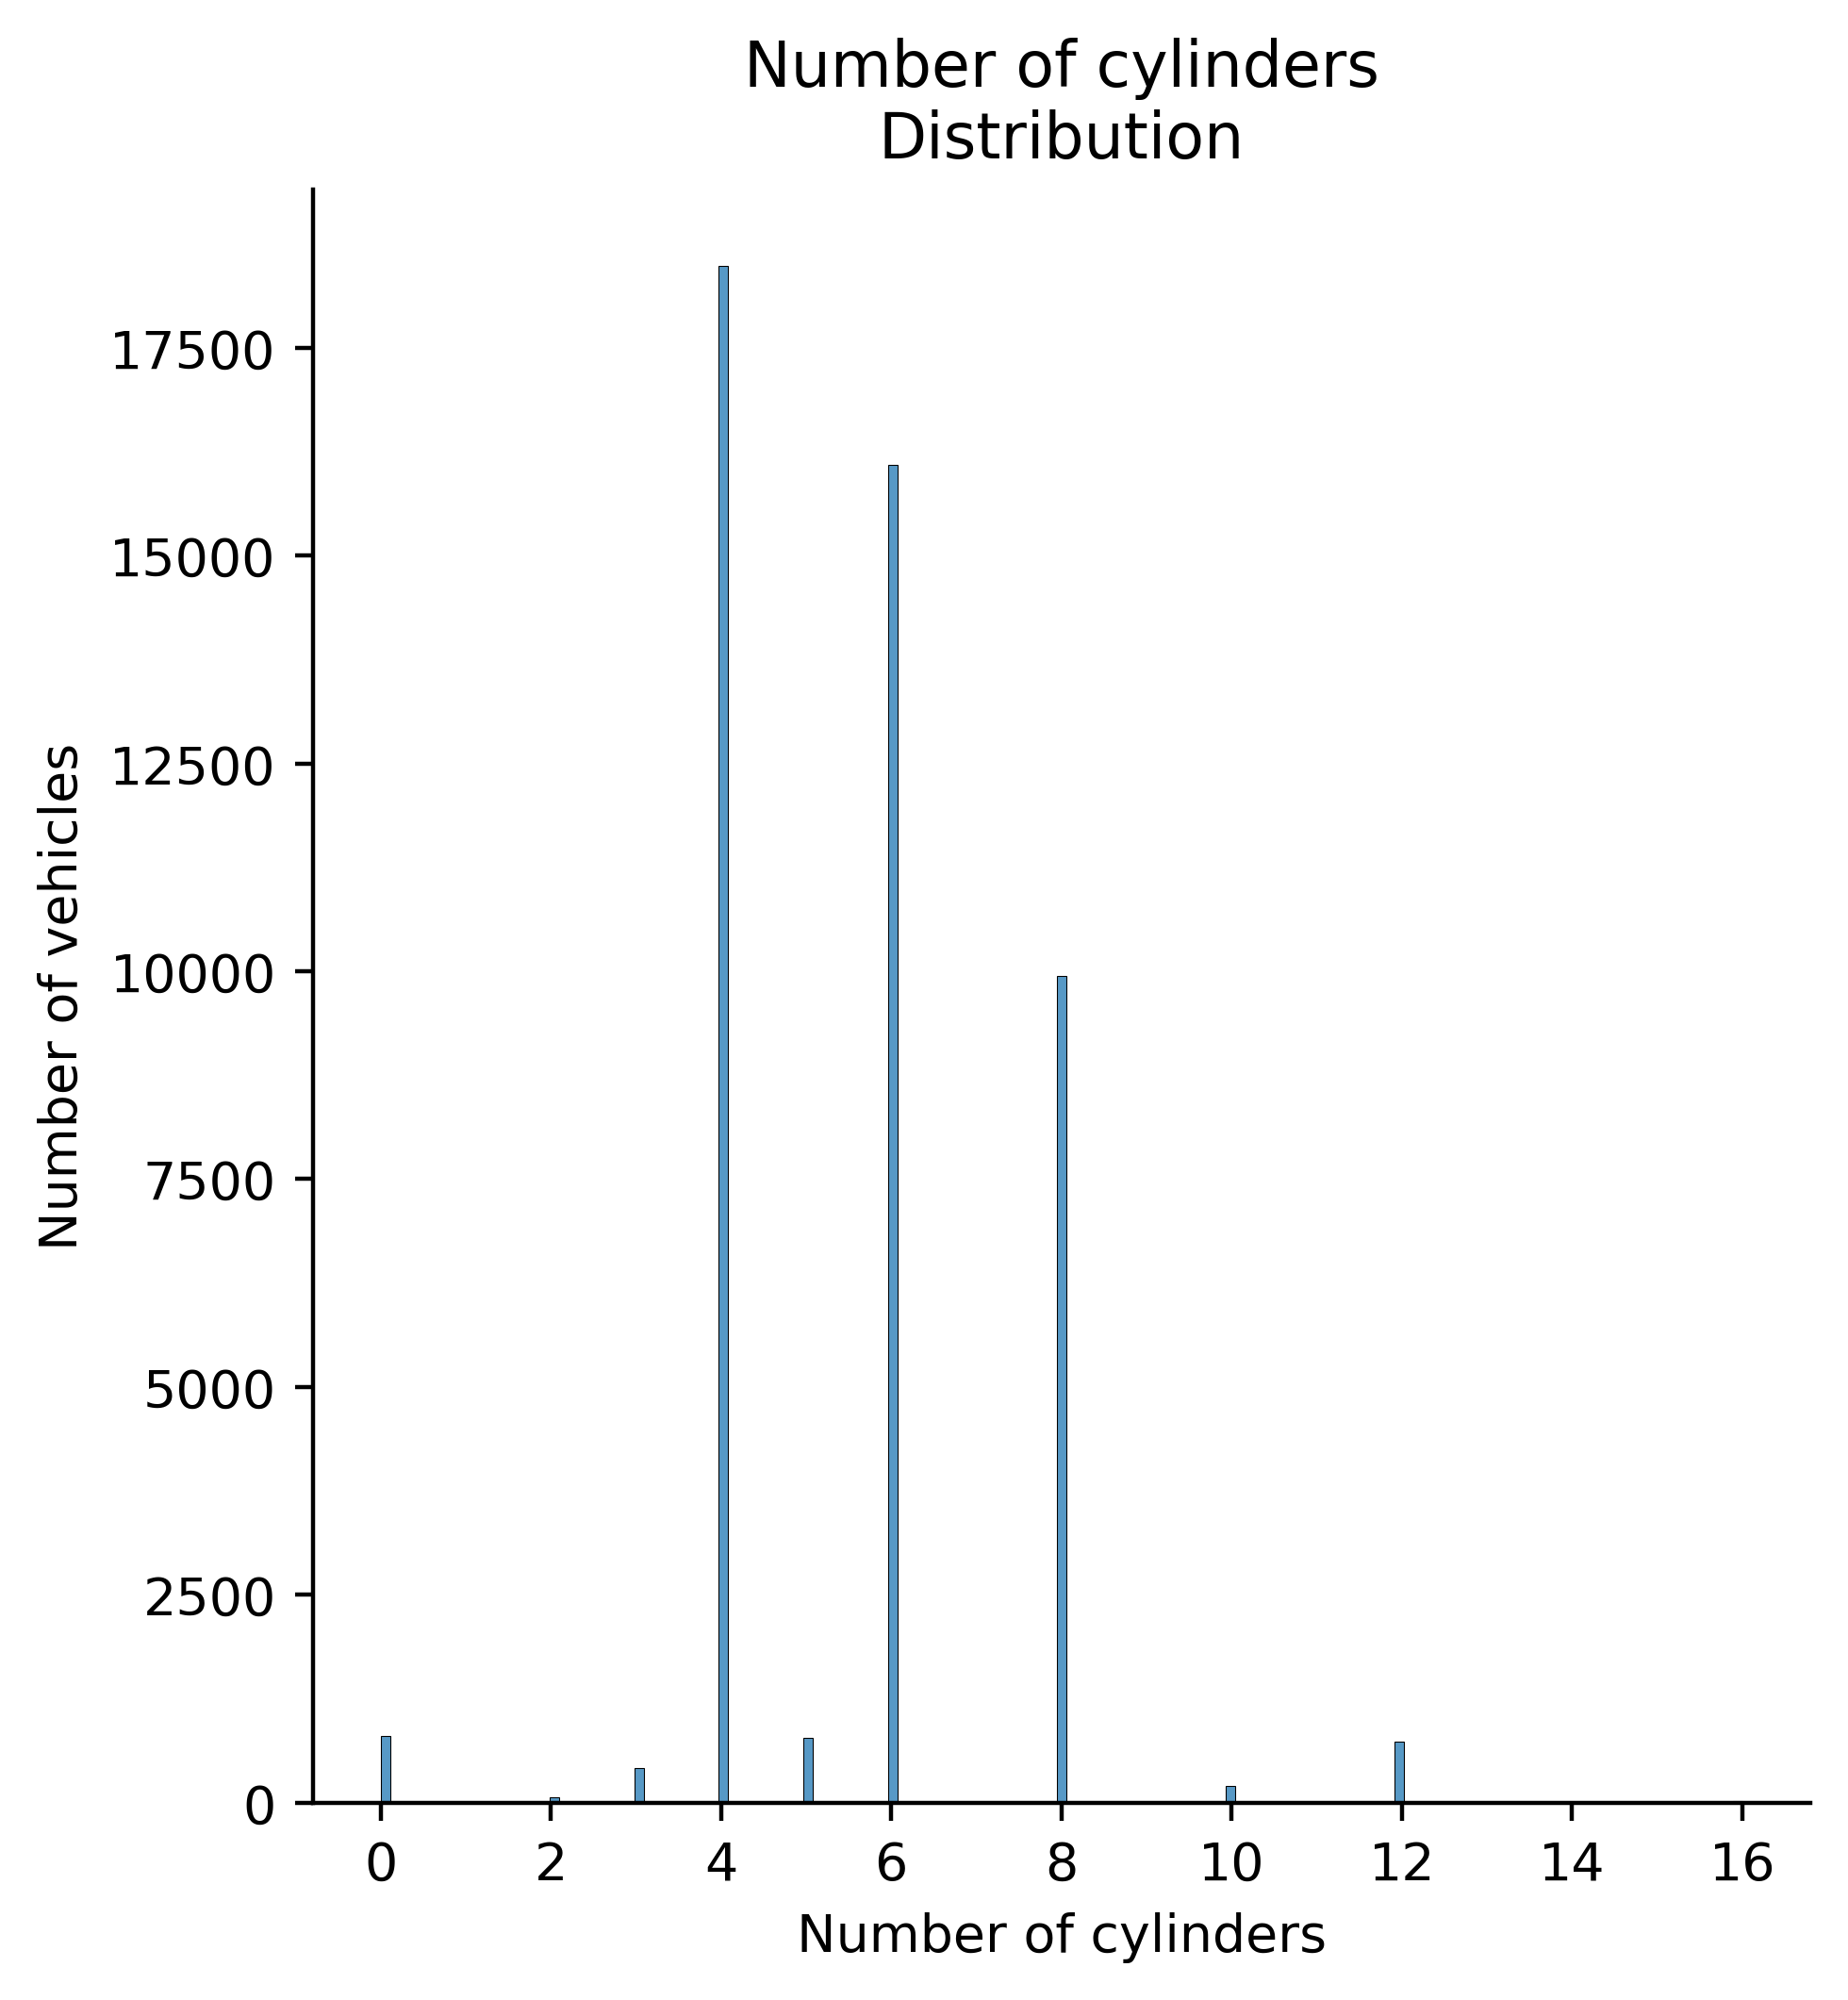

In [419]:
plt.rcParams["figure.dpi"]=400
sns.displot(data = veh_data, x = "cylinders", kind = "hist")
plt.title("Number of cylinders\nDistribution")
plt.ylabel("Number of vehicles")
plt.xlabel("Number of cylinders")
plt.show()

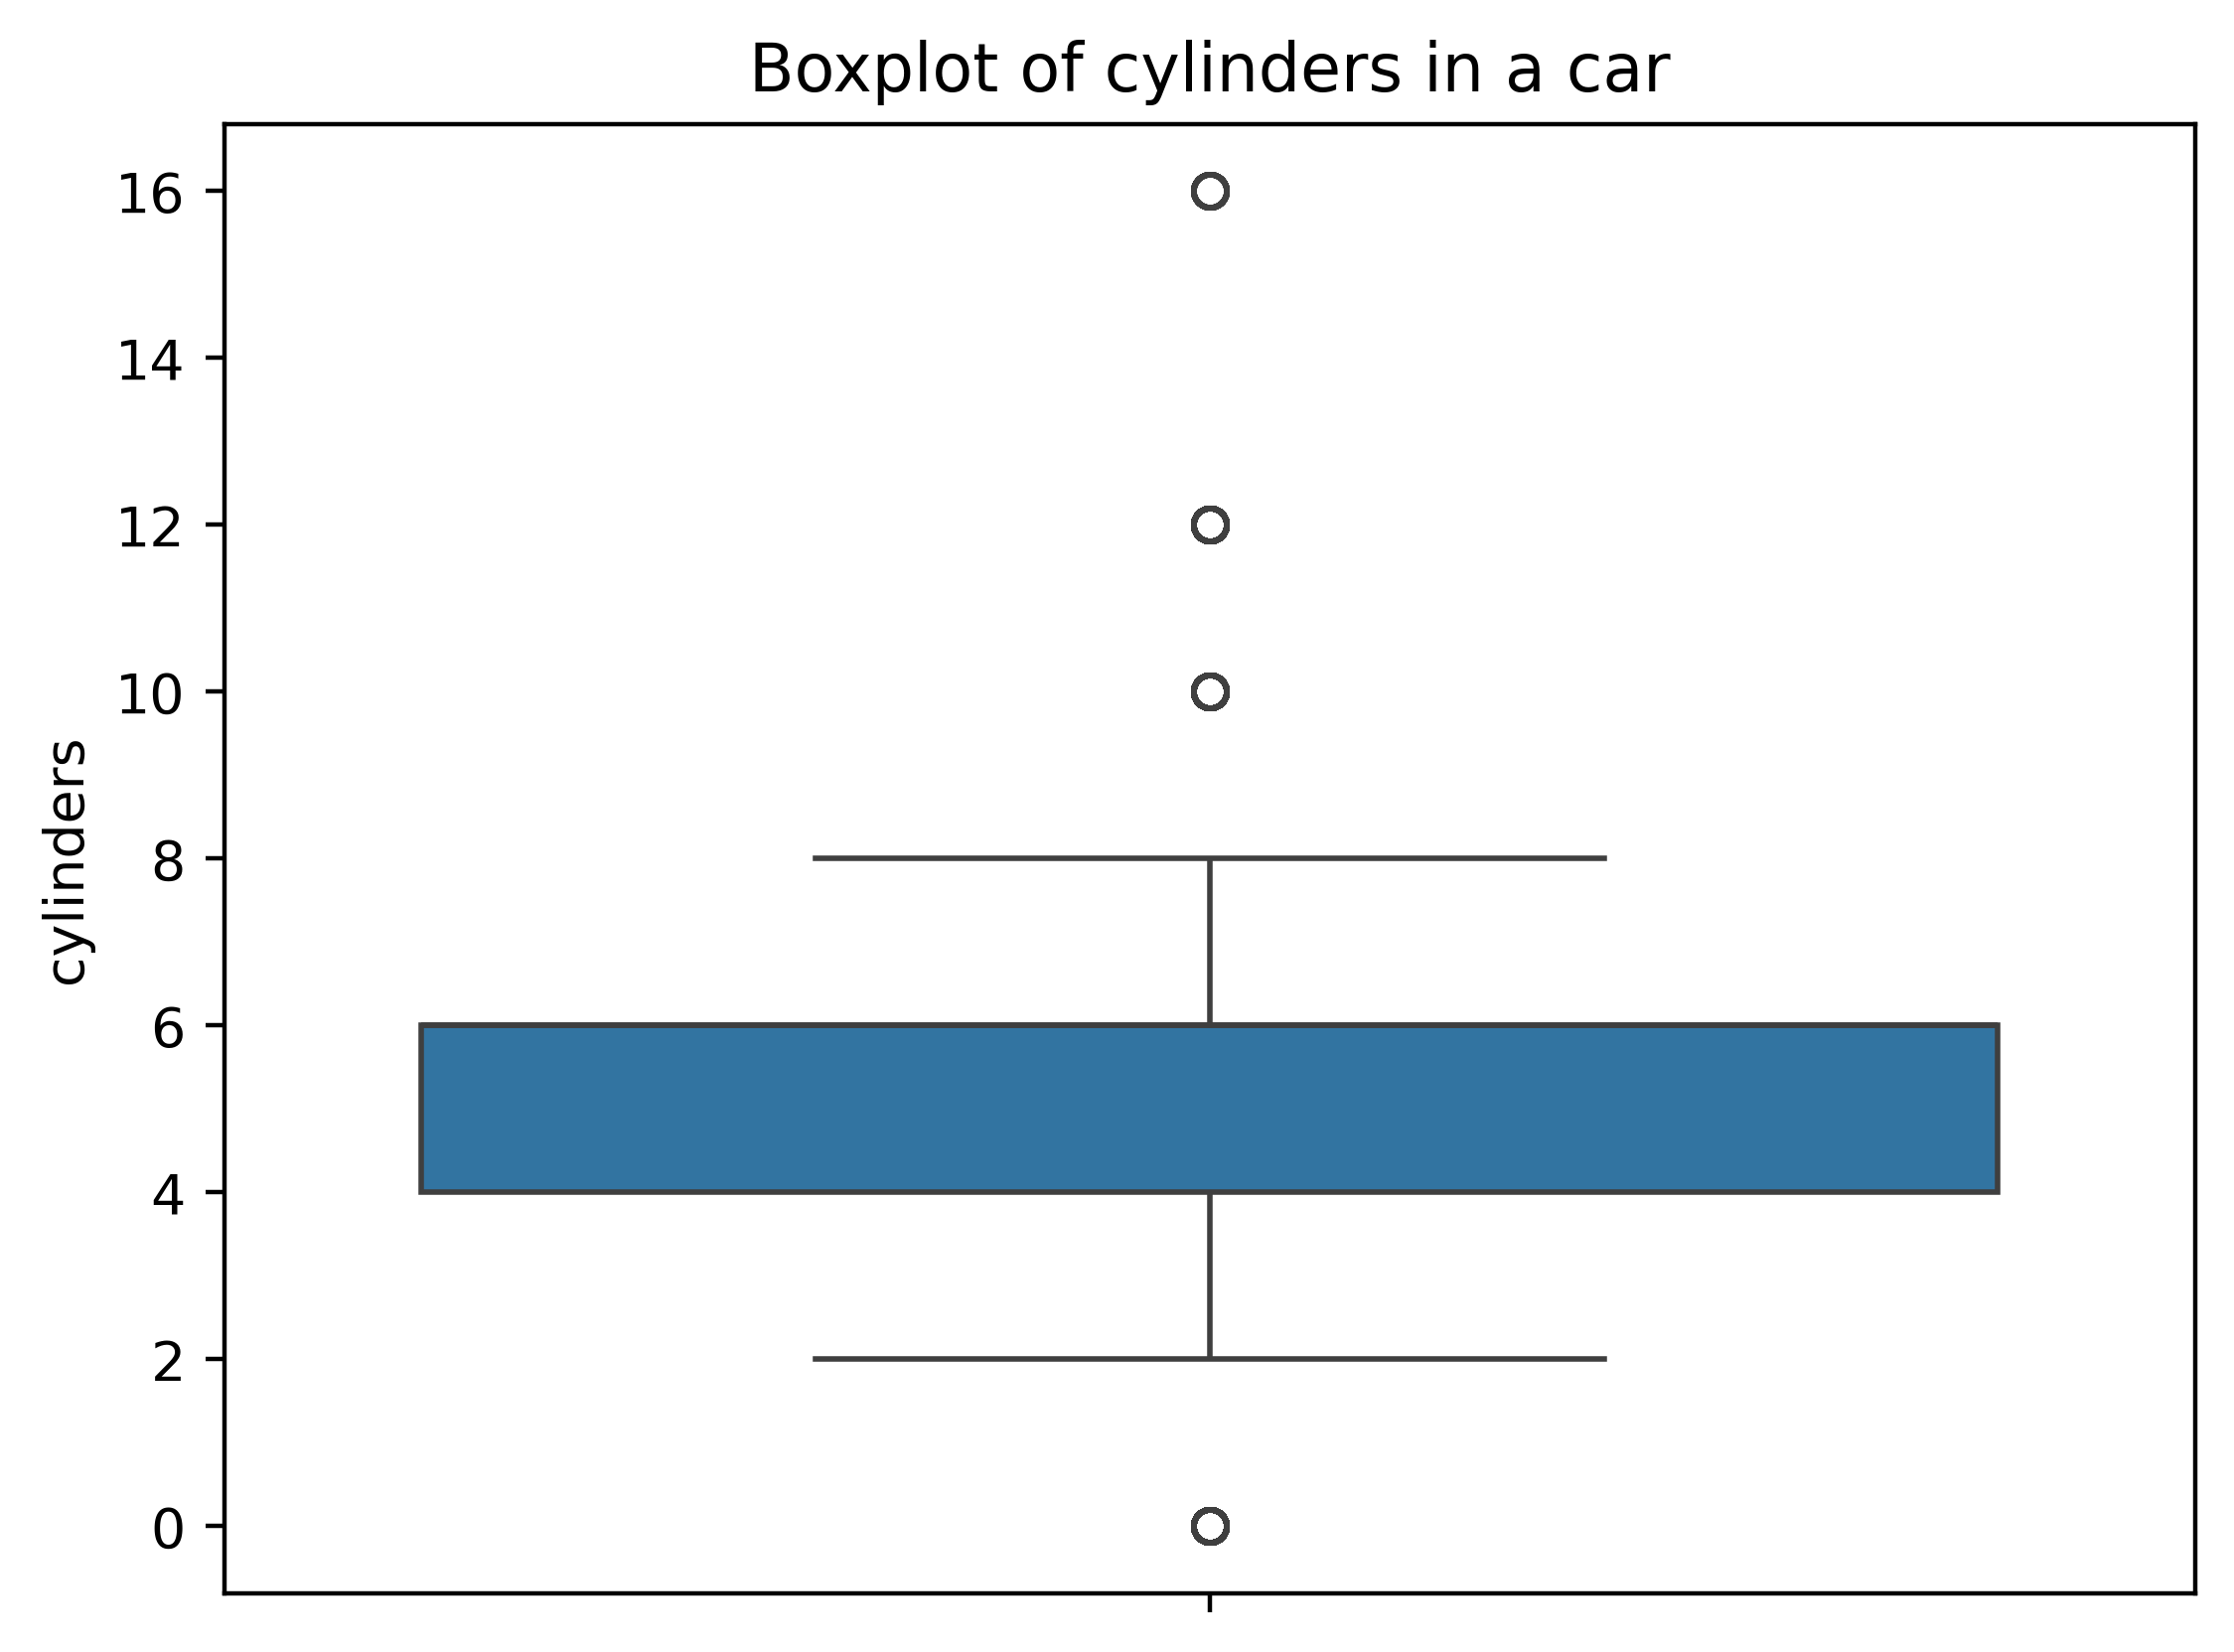

In [420]:

sns.boxplot(data = veh_data, y ="cylinders")
plt.title("Boxplot of cylinders in a car")
plt.show()


In [421]:
cylinder_info = veh_data.groupby("make", as_index = False).agg({
                "cylinders":[min, max, mode]
}).sort_values(("cylinders","max"), ascending = False).reset_index(drop=True)

C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_15432\765768739.py:1: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  cylinder_info = veh_data.groupby("make", as_index = False).agg({
C:\Users\Emmanuel\AppData\Local\Temp\ipykernel_15432\765768739.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cylinder_info = veh_data.groupby("make", as_index = False).agg({


In [422]:
cylinder_info["cylinders"] = cylinder_info["cylinders"].astype(int)

In [423]:
cylinder_info[("cylinders","min_interval")] = cylinder_info[("cylinders","mode")]-cylinder_info[("cylinders","min")] 
cylinder_info[("cylinders","max_interval")] = cylinder_info[("cylinders","max")]-cylinder_info[("cylinders","mode")] 

In [424]:
cylinder_info.head(7)

make cylinders                                   
                               min max mode min_interval max_interval
0                Bugatti        16  16   16            0            0
1                   Audi         0  12    4            4            8
2                Bentley         6  12    8            2            4
3           Aston Martin         6  12   12            6            0
4                 Vector         8  12   12            4            0
5             Volkswagen         0  12    4            4            8
6  Wallace Environmental         4  12    8            4            4

In [425]:
plot_data = cylinder_info.sort_values(("cylinders","mode"), ascending = False).head(10)
errorbar = [plot_data[("cylinders","min_interval")].tolist(),plot_data[("cylinders","max_interval")].astype(int).tolist()]

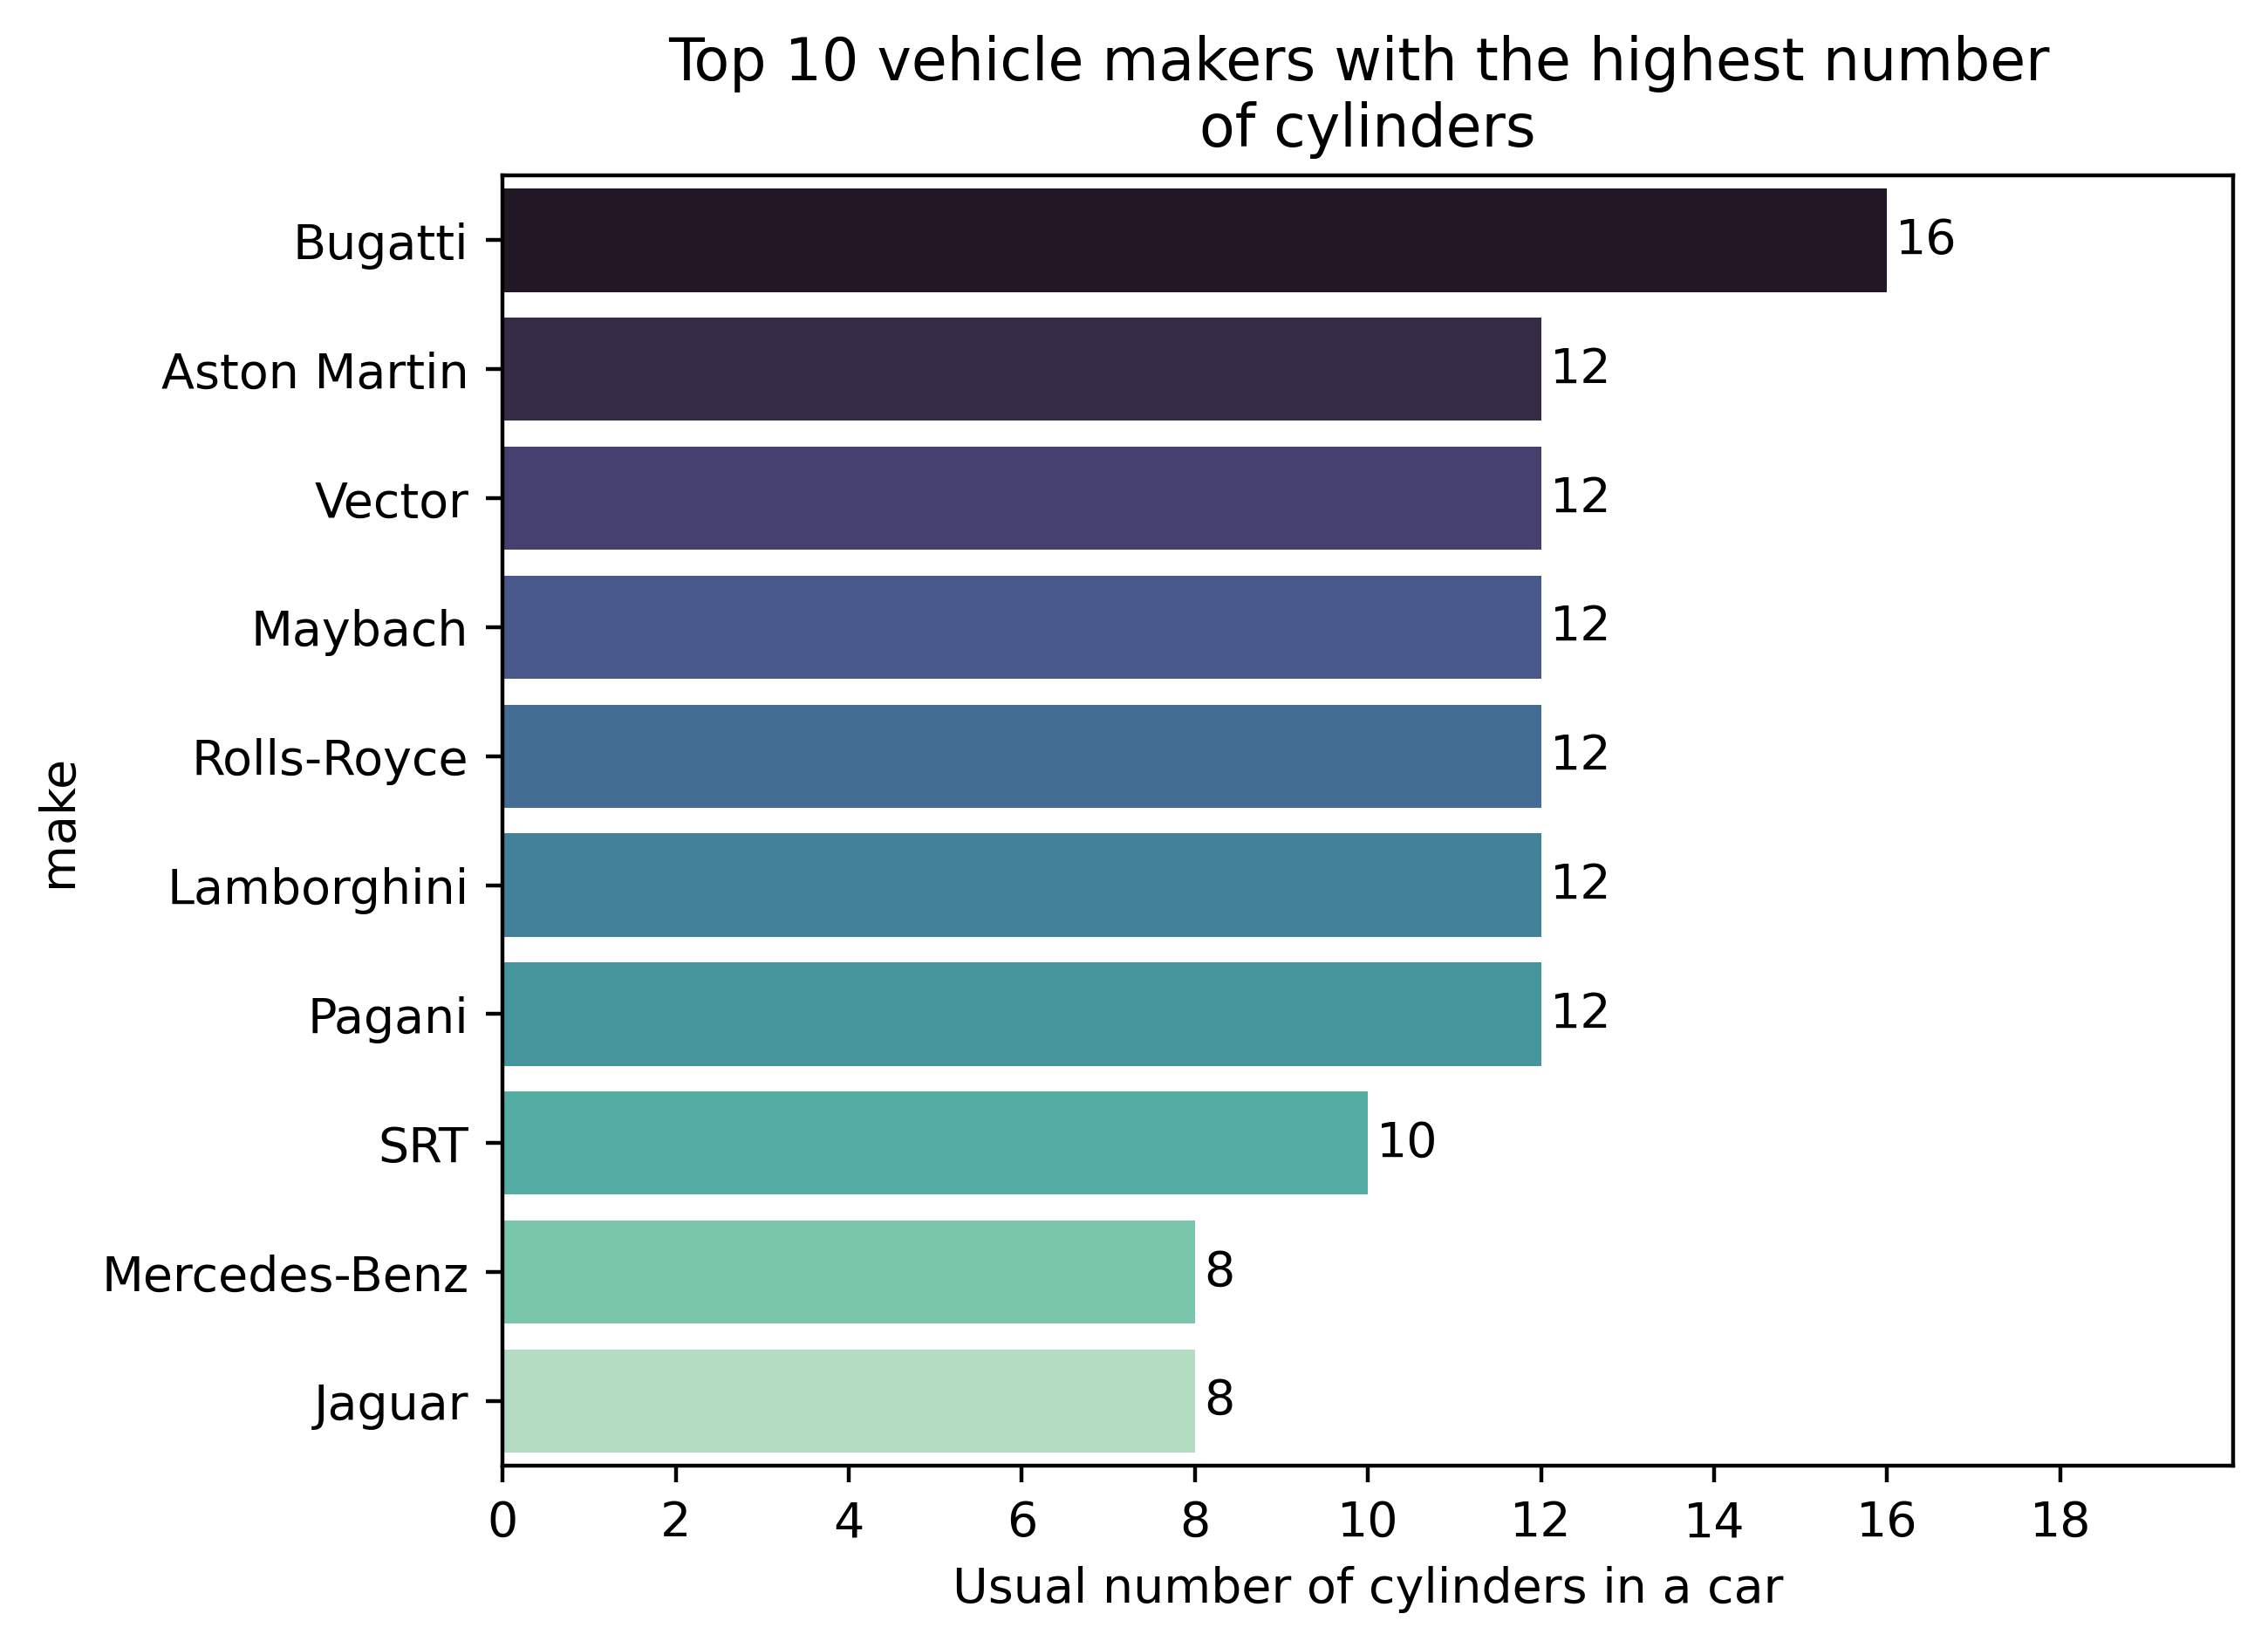

In [426]:

fig = sns.barplot(data = plot_data, y = "make", x = ("cylinders","mode"), hue = "make",  palette = sns.color_palette("mako", len(plot_data)))
#fig.errorbar(xerr= errorbar, y = plot_data["make"],  x=plot_data[("cylinders","mode")], fmt="none", c = "black")

for bar in fig.patches:
    width = bar.get_width()  # barwidth (equals to "mode")
    y = bar.get_y() + bar.get_height() / 2  # y position
    fig.text(width + 0.1, y, f'{int(width)}', va='center')  # Coloca el texto en el gráfico

fig.set_xlim(0, 20)
plt.xticks(range(0,20,2))
plt.title(f"Top {len(plot_data)} vehicle makers with the highest number \nof cylinders")
plt.xlabel("Usual number of cylinders in a car")
plt.show()

Also, as in this case there exist cars with 12 cylinders, even when those values are considered as outliers, they will be stored as well

##### ***engine_displacement*** column

In [427]:
veh_metadata.query("title == 'Engine displacement'")

,title,description,type,unit
displ,Engine displacement,engine displacement in liters,number,NaN


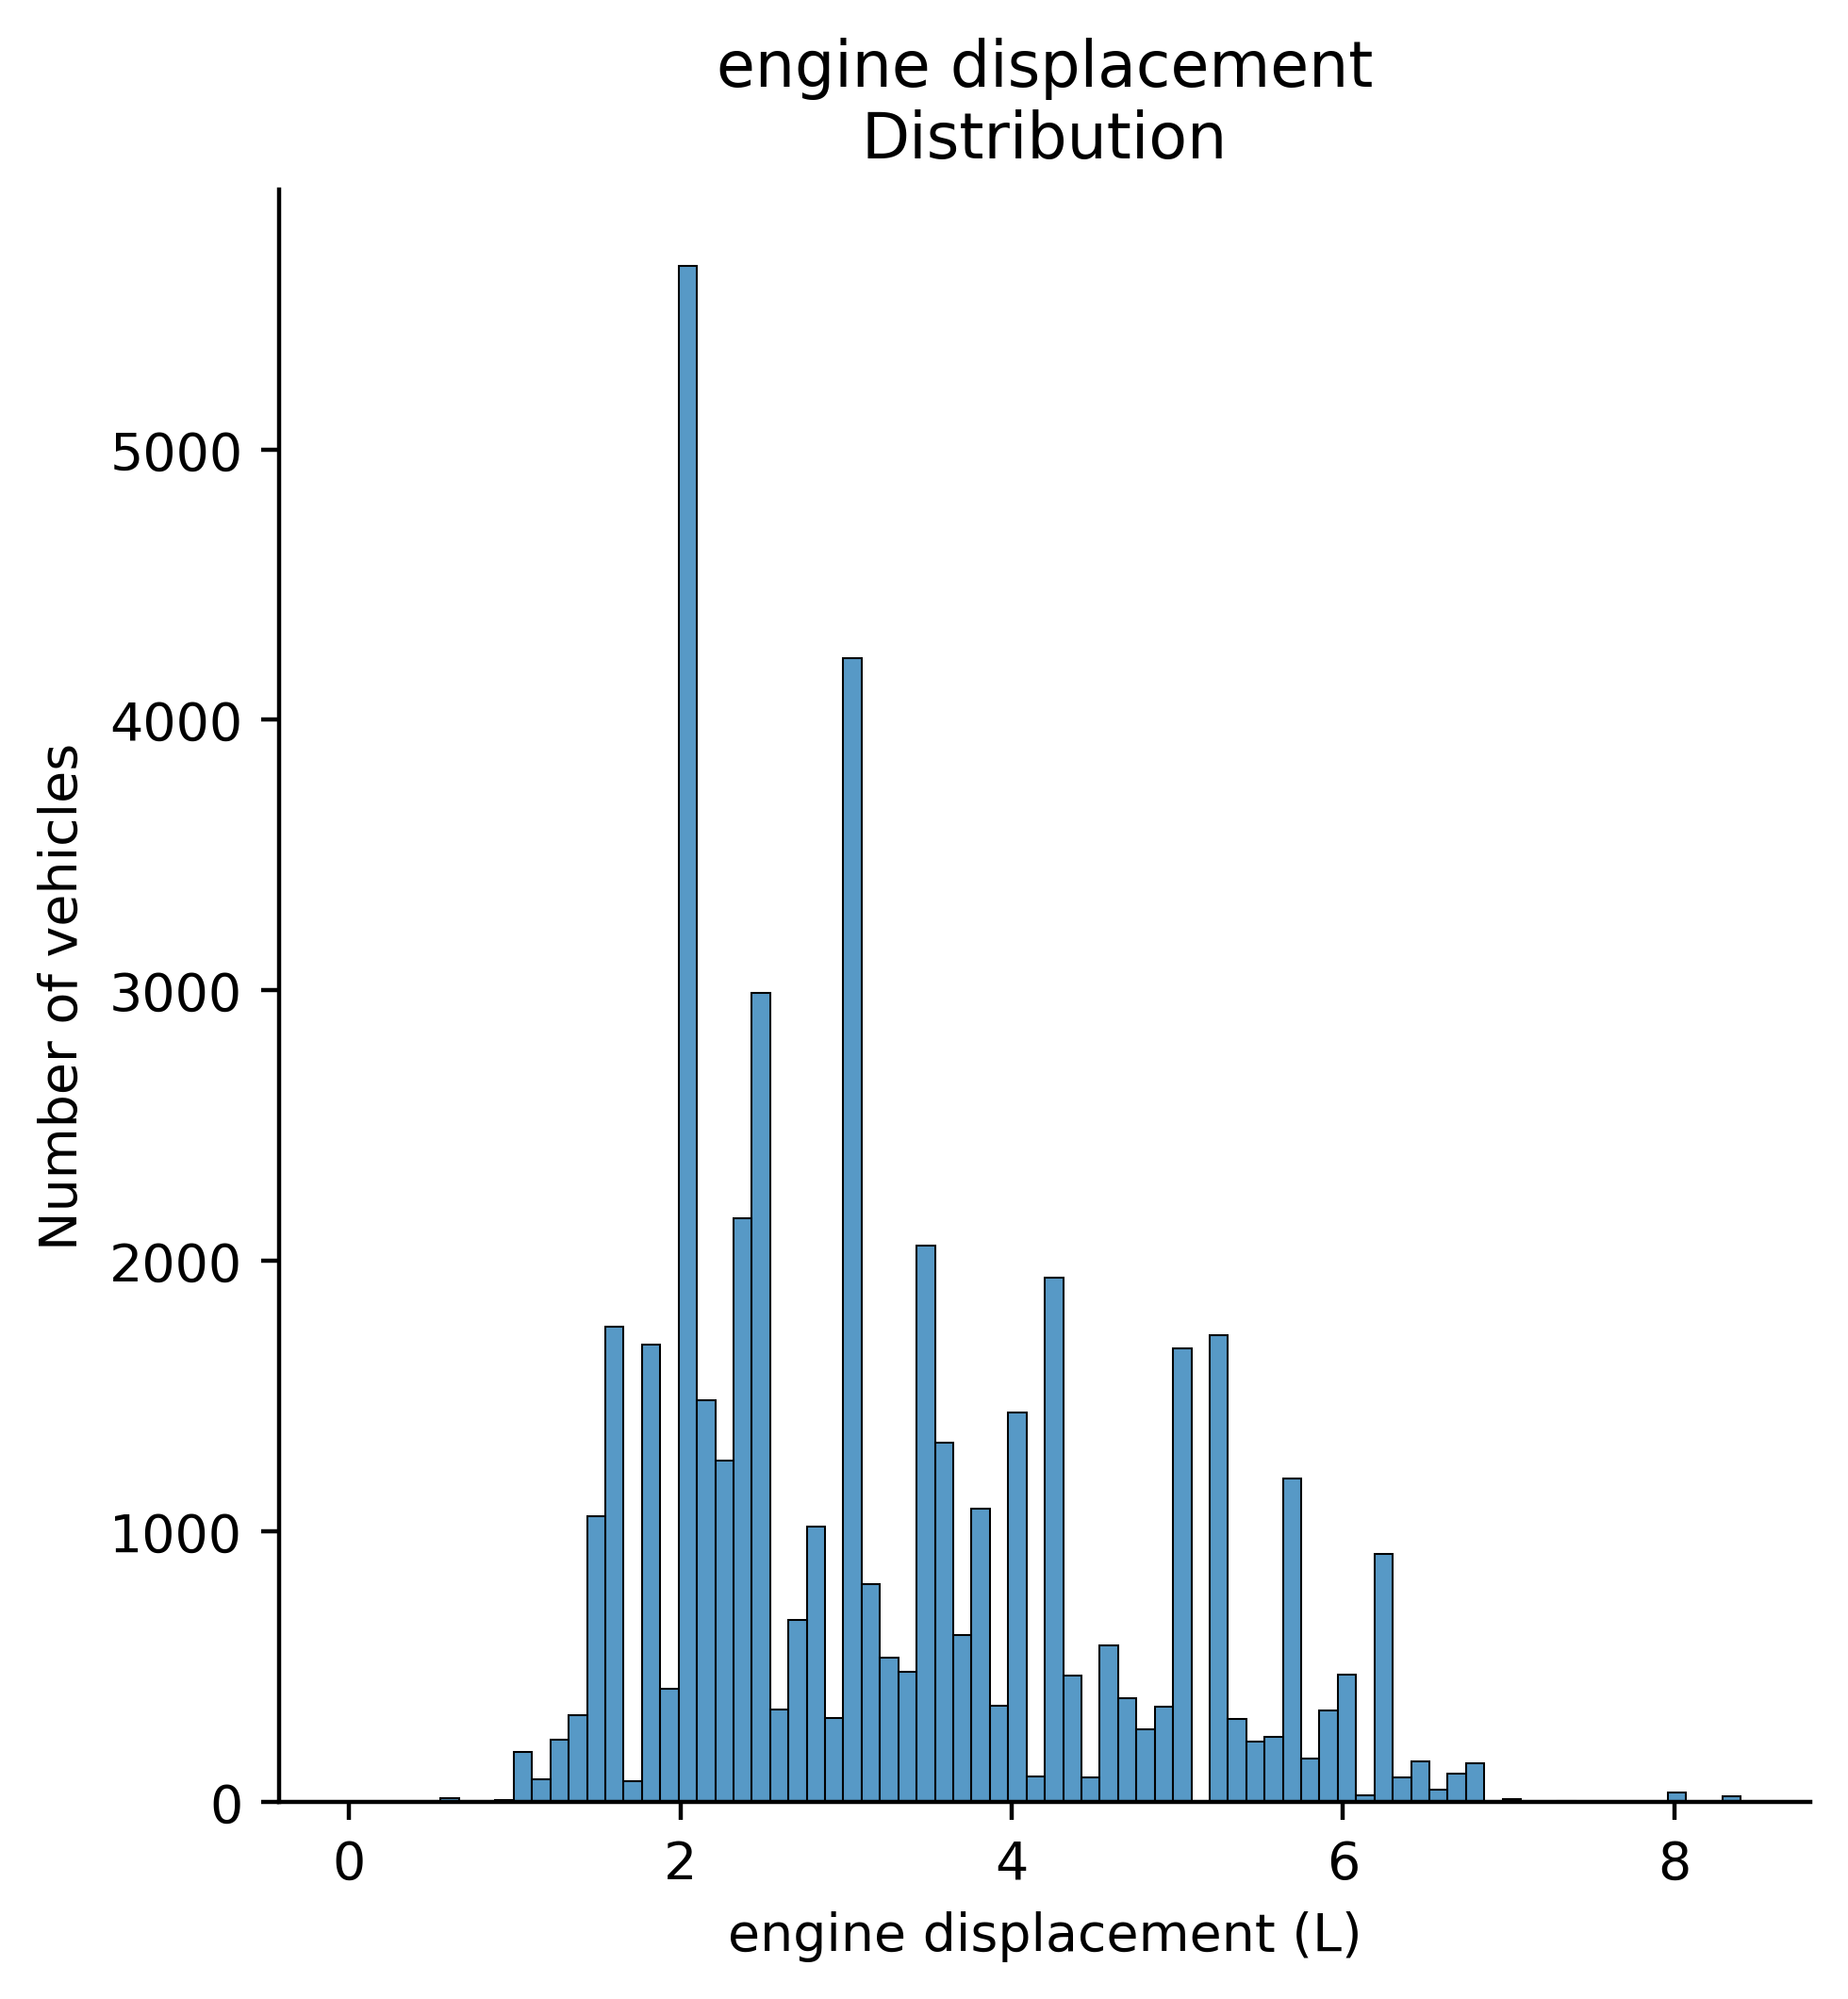

In [428]:
plt.rcParams["figure.dpi"]=400
sns.displot(data = veh_data, x = "engine_displacement", kind = "hist")
plt.title("engine displacement\nDistribution")
plt.ylabel("Number of vehicles")
plt.xlabel("engine displacement (L)")
plt.show()

In [429]:
veh_data[cols_to_fix].head()

NameError: name 'cols_to_fix' is not defined

#### Non-numerical Data

In [77]:
cat_data = veh_data[[x for x in veh_data.columns if x not in num_data.columns]]

In [78]:
cat_data.describe(include="all")

,make,model,drive,epa_model_type_index,engine_descriptor,fuel_type,fuel_type1,id,mpg_data,phev_blended,transmission,vehicle_size_class,year,guzzler,transmission_descriptor,t_charger,s_charger,atv_type,fuel_type2,epa_range_for_fuel_type2,electric_motor,mfr_code,c240dscr,c240b_dscr,created_on,modified_on,start-stop,basemodel
count,47523,47523,46337,47523,30081,47523,47523,47523,47482,47523,47512,47523,47523,2763,15044,10335,1006,5321,1896,1891,2437,16715,141,135,47523,47523,15834,47523
unique,144,5064,7,2765,602,15,7,47523,2,2,40,34,42,3,52,1,1,9,4,245,400,56,5,7,455,298,2,1451
top,Chevrolet,F150 Pickup 2WD,Front-Wheel Drive,0,FFS,Regular,Regular Gasoline,37305,N,false,Automatic 4-spd,Compact Cars,1984,G,CLKUP,T,S,FFV,E85,290,48V Li-Ion,GMX,standard charger,80 amp dual charger,2013-01-01,2013-01-01,N,Sierra
freq,4420,236,15492,12597,8861,28890,30426,1,33299,47240,11048,6400,1964,1784,7809,10335,1006,1526,1526,76,355,2384,130,55,34193,29169,8621,733


In [98]:
def factorize_categorical(df:pd.DataFrame)->tuple[pd.DataFrame, list]:
    cat_features = [x for x in df.columns if x not in df._get_numeric_data().columns]
    new_df = df.copy()
    encoders = {}
    for col in cat_features:
        new_vals, uniques = df[col].factorize() # new_vals are the values encoded, with the same order as the original, is an np.array
        new_df[col] = pd.Series(new_vals)
        encoders[col] = {x:uniques[x] for x in range(len(uniques))}
    return new_df, encoders

In [114]:
df_encoded, encoders = factorize_categorical(veh_data)
Y = df_encoded.pop("city_mpg_for_fuel_type1")
X = df_encoded

In [117]:
mutual_info_scores = mutual_info_regression(X, Y, discrete_features=list(encoders.keys()))

ValueError: Input X contains NaN.

### Vehicle consumption data

In [84]:
def getting_veh_consumption(make, basemodel, year, limit = 50):
    api_url = rf"https://api.api-ninjas.com/v1/cars?limit={limit}&model={basemodel}&make={make}&year={year}"
    try:
        response = requests.get(url=api_url, headers = {'X-Api-Key': f'{os.getenv("NINJA_API_KEY")}'})
        return response    
    except:
        print(f"An error occur: {response.text}")
        return response

In [85]:
diff_models = veh_data[["make","basemodel","year"]].drop_duplicates().sort_values("year",ascending=False).reset_index(drop=True)


In [86]:
len(diff_models)

11508

In [87]:
limit = 50 #max number of rows that can be retrieved from the api
for idx in range(len(diff_models)):
    print(f"request number: {idx} out of {len(diff_models)}")
    make = diff_models.make[idx]
    basemodel = diff_models.basemodel[idx]
    year = diff_models.year[idx]
    response = getting_veh_consumption(make = make, basemodel = basemodel, year = year)
    if response == 200:
        df = pd.read_json(json.loads(response.text))
        df = df.groupby(["make","model","fueltype","year"], as_index = False)[["combination_mpg","city_mpg","highway_mpg"]].mean()
        if idx == 0:
            veh_consumpt = df
        else:
            veh_consumpt = pd.concat([veh_consumpt,df], ignore_index = True)
    else:
        continue  
  
    

request number: 0 out of 11508
request number: 1 out of 11508
request number: 2 out of 11508
request number: 3 out of 11508
request number: 4 out of 11508
request number: 5 out of 11508
request number: 6 out of 11508
request number: 7 out of 11508
request number: 8 out of 11508
request number: 9 out of 11508
request number: 10 out of 11508
request number: 11 out of 11508
request number: 12 out of 11508
request number: 13 out of 11508
request number: 14 out of 11508
request number: 15 out of 11508
request number: 16 out of 11508
request number: 17 out of 11508
request number: 18 out of 11508
request number: 19 out of 11508
request number: 20 out of 11508
request number: 21 out of 11508
request number: 22 out of 11508
request number: 23 out of 11508
request number: 24 out of 11508
request number: 25 out of 11508
request number: 26 out of 11508
request number: 27 out of 11508
request number: 28 out of 11508
request number: 29 out of 11508
request number: 30 out of 11508
request number: 31

UnboundLocalError: cannot access local variable 'response' where it is not associated with a value

## Number of vehicles per year and per maker

In [4]:
num_of_veh_per_year_and_maker = veh_data.groupby("year", as_index = False).make.value_counts(ascending = False)

In [5]:
num_of_veh_per_year_and_maker.head()

,year,make,count
0,1984,Chevrolet,250
1,1984,Ford,236
2,1984,Dodge,191
3,1984,GMC,156
4,1984,Pontiac,99


In [6]:
fig = px.line(
        data_frame=num_of_veh_per_year_and_maker,
        x = "year",
        y = "count",
        color = "make",
        title = "Vehicles catalog per maker and year"
        )

fig.update_layout(
                plot_bgcolor = "black",
                paper_bgcolor = "black",
                xaxis = {"showgrid":False},
                yaxis = {"showgrid":False}
                )
     

## Vehicle Class through time

##  

In [8]:
vclass_history = veh_data.groupby("year", as_index = False).vclass.value_counts()

In [9]:
vclass_history.head()

,year,vclass,count
0,1984,Subcompact Cars,370
1,1984,Compact Cars,245
2,1984,Midsize Cars,217
3,1984,Special Purpose Vehicle 4WD,147
4,1984,Standard Pickup Trucks 2WD,143


In [10]:
fig2 = px.line(
    data_frame=vclass_history,
    x="year",
    y="count",
    color = "vclass",
    title = "Vehicle Class through time"
)
fig2.update_layout(
    plot_bgcolor = "black",
    paper_bgcolor = "black",
    xaxis = {"showgrid":False},
    yaxis = {"showgrid":False}
)


## Types of fuels per type

In [26]:
fuels_history = veh_data.groupby(["year"], as_index = False).fueltype.value_counts()
fig3 = px.line(
        data_frame=fuels_history,
        x = "year",
        y = "count",
        color = "fueltype",
        title = "Fuels used by cars",
        labels={"count":"number of cars using the fuel"}
        )
fig3.update_layout(
    plot_bgcolor = "black",
    paper_bgcolor = "black",
    xaxis = {"showgrid":False},
    yaxis = {"showgrid":False}
)

## Autonomy through time

In [43]:
autonomy_history = veh_data.groupby(["year","make"], as_index=False).citycd.mean()
autonomy_history.head()

,year,make,citycd
0,1984,AM General,0.0
1,1984,Alfa Romeo,0.0
2,1984,American Motors Corporation,0.0
3,1984,Aston Martin,0.0
4,1984,Audi,0.0


In [46]:
veh_data.city08u.value_counts()

city08u
0.0000      29656
17.0000       118
18.0000       115
18.3385       106
19.0003        91
18.1170        82
19.0000        76
14.8182        76
15.9536        76
16.0000        76
20.0000        73
14.0551        72
14.9703        71
19.2200        70
17.1523        68
21.7524        68
18.1909        67
15.0000        66
22.3233        65
19.6583        64
21.3942        64
22.0000        62
21.0000        62
18.4122        61
19.4394        60
14.8943        60
19.5853        60
18.7801        59
21.5376        59
25.0000        59
20.9627        58
14.0000        58
19.9494        58
18.5595        57
15.8028        57
16.3295        56
20.1673        56
18.8536        55
19.0736        55
20.8906        54
16.1793        54
16.5545        54
29.0000        52
19.8039        52
15.0462        51
16.9285        51
18.7066        50
22.0382        50
20.0221        50
15.4251        50
21.4659        49
19.8767        49
16.6294        49
14.1316        48
15.5764        48
16

In [20]:
veh_metadata

,title,description,type,unit
make,Make,manufacturer (division),string,NaN
model,Model,model name (carline),string,NaN
barrels08,Annual Petroleum Consumption For Fuel Type1,annual petroleum consumption in barrels for fu...,number,NaN
barrelsa08,Annual Petroleum Consumption For Fuel Type2,annual petroleum consumption in barrels for fu...,number,NaN
charge120,Time to charge at 120V,time to charge an electric vehicle in hours at...,number,NaN
charge240,Time to charge at 240V,time to charge an electric vehicle in hours at...,number,NaN
city08,City Mpg For Fuel Type1,city MPG for fuelType1,integer,NaN
city08u,Unrounded City Mpg For Fuel Type1 (2),unrounded city MPG for fuelType1 (2),number,NaN
citya08,City Mpg For Fuel Type2,city MPG for fuelType2,integer,NaN
citya08u,Unrounded City Mpg For Fuel Type2,unrounded city MPG for fuelType2,number,NaN
